In [5]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import tensorflow as tf
from tensorflow import keras

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import decode_predictions
from keras.models import Model, load_model
import keras.backend as K

import model as tcav_model
import tcav as tcav
import utils as utils
import activation_generator as act_gen
import tensorflow as tf
import utils_plot as utils_plot


from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

import numpy as np
from numpy.linalg import norm

import pickle
#from bunch import bunchify

import cav as cav

from os import listdir
from os.path import isfile, join
import operator
from PIL import Image
from keras.preprocessing import image

import os
import math

import PIL.Image
from sklearn.metrics import pairwise
import matplotlib.pyplot as plt
from keras.applications.inception_v3 import preprocess_input



Using TensorFlow backend.


In [6]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [7]:
model = load_model('v3_model.h5')

/Users/tyler/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [8]:
sess = K.get_session()

endpoints_v3 = dict(
    input=model.inputs[0].name,
    input_tensor=model.inputs[0],
    logit=model.outputs[0].name,
    prediction=model.outputs[0].name,
    prediction_tensor=model.outputs[0],
)

tf.logging.set_verbosity(0)

working_dir = '/home/tyler/Desktop/tcav_on_azure'
working_dir = '/Users/tyler/Desktop/dissertation/programming/tcav_on_azure'


label_path = os.path.join(working_dir,'labels.txt')

mymodel = tcav_model.KerasModelWrapper(sess, 
        label_path, [299, 299, 3], endpoints_v3, 
        'InceptionV3_public', (-1, 1))

In [9]:
activation_dir

NameError: name 'activation_dir' is not defined

In [ ]:
## Run specific CAV
source_dir = working_dir + '/concepts/'
activation_dir =  working_dir + '/activations/'

hparams = tf.contrib.training.HParams(model_type='linear', alpha=.1)

#bottleneck = bottlenecks[0]
bottleneck = 'mixed9'
target_class = 'zebra'
concepts = ['banded_sub_1', 'random500_0']

act_generator = act_gen.ImageActivationGenerator(mymodel, source_dir, activation_dir, max_examples=50)
acts = act_generator.process_and_load_activations([bottleneck], concepts + [target_class])
cav.get_or_train_cav(concepts,bottleneck,acts,cav_hparams=hparams,cav_dir='cavs')

In [37]:
## CAV loop
target_class = 'zebra'
concepts = ['knitted_sub_1', 'random500_0']

bn_names = ['mixed0','mixed1','mixed2','mixed3','mixed4','mixed5','mixed6','mixed7','mixed8','mixed9']
for bottleneck in  bn_names:
    acts = act_generator.process_and_load_activations([bottleneck], concepts + [target_class])
    cav.get_or_train_cav(concepts,bottleneck,acts,cav_hparams=hparams,cav_dir='cavs')


['knitted_sub_1', 'random500_0', 'zebra']
INFO:tensorflow:/home/tyler/Desktop/tcav_on_azure/activations/acts_knitted_sub_1_mixed0 does not exist, Making one...
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_random500_0_mixed0 shape (50, 35, 35, 256)
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_zebra_mixed0 shape (50, 35, 35, 256)
INFO:tensorflow:Training CAV ['knitted_sub_1', 'random500_0'] - mixed0 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:using new version


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


INFO:tensorflow:acc per class {'knitted_sub_1': 0.7058823529411765, 'random500_0': 1.0, 'overall': 0.8484848484848485}
INFO:tensorflow:cavs/knitted_sub_1-random500_0-mixed0-linear-0.1_test.pkl
INFO:tensorflow:did save save_path_lin_sep
['knitted_sub_1', 'random500_0', 'zebra']
INFO:tensorflow:/home/tyler/Desktop/tcav_on_azure/activations/acts_knitted_sub_1_mixed1 does not exist, Making one...
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_random500_0_mixed1 shape (50, 35, 35, 288)
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_zebra_mixed1 shape (50, 35, 35, 288)
INFO:tensorflow:Training CAV ['knitted_sub_1', 'random500_0'] - mixed1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:using new version


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


INFO:tensorflow:acc per class {'knitted_sub_1': 1.0, 'random500_0': 0.7647058823529411, 'overall': 0.8787878787878788}
INFO:tensorflow:cavs/knitted_sub_1-random500_0-mixed1-linear-0.1_test.pkl
INFO:tensorflow:did save save_path_lin_sep
['knitted_sub_1', 'random500_0', 'zebra']
INFO:tensorflow:/home/tyler/Desktop/tcav_on_azure/activations/acts_knitted_sub_1_mixed2 does not exist, Making one...
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_random500_0_mixed2 shape (50, 35, 35, 288)
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_zebra_mixed2 shape (50, 35, 35, 288)
INFO:tensorflow:Training CAV ['knitted_sub_1', 'random500_0'] - mixed2 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:using new version


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


INFO:tensorflow:acc per class {'knitted_sub_1': 0.9375, 'random500_0': 1.0, 'overall': 0.9696969696969697}
INFO:tensorflow:cavs/knitted_sub_1-random500_0-mixed2-linear-0.1_test.pkl
INFO:tensorflow:did save save_path_lin_sep
['knitted_sub_1', 'random500_0', 'zebra']
INFO:tensorflow:/home/tyler/Desktop/tcav_on_azure/activations/acts_knitted_sub_1_mixed3 does not exist, Making one...
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_random500_0_mixed3 shape (50, 17, 17, 768)
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_zebra_mixed3 shape (50, 17, 17, 768)
INFO:tensorflow:Training CAV ['knitted_sub_1', 'random500_0'] - mixed3 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:using new version


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


INFO:tensorflow:acc per class {'knitted_sub_1': 1.0, 'random500_0': 0.6470588235294118, 'overall': 0.8181818181818182}
INFO:tensorflow:cavs/knitted_sub_1-random500_0-mixed3-linear-0.1_test.pkl
INFO:tensorflow:did save save_path_lin_sep
['knitted_sub_1', 'random500_0', 'zebra']
INFO:tensorflow:/home/tyler/Desktop/tcav_on_azure/activations/acts_knitted_sub_1_mixed4 does not exist, Making one...
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_random500_0_mixed4 shape (50, 17, 17, 768)
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_zebra_mixed4 shape (50, 17, 17, 768)
INFO:tensorflow:Training CAV ['knitted_sub_1', 'random500_0'] - mixed4 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:using new version


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


INFO:tensorflow:acc per class {'knitted_sub_1': 0.9411764705882353, 'random500_0': 1.0, 'overall': 0.9696969696969697}
INFO:tensorflow:cavs/knitted_sub_1-random500_0-mixed4-linear-0.1_test.pkl
INFO:tensorflow:did save save_path_lin_sep
['knitted_sub_1', 'random500_0', 'zebra']
INFO:tensorflow:/home/tyler/Desktop/tcav_on_azure/activations/acts_knitted_sub_1_mixed5 does not exist, Making one...
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_random500_0_mixed5 shape (50, 17, 17, 768)
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_zebra_mixed5 shape (50, 17, 17, 768)
INFO:tensorflow:Training CAV ['knitted_sub_1', 'random500_0'] - mixed5 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:using new version


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


INFO:tensorflow:acc per class {'knitted_sub_1': 0.9375, 'random500_0': 1.0, 'overall': 0.9696969696969697}
INFO:tensorflow:cavs/knitted_sub_1-random500_0-mixed5-linear-0.1_test.pkl
INFO:tensorflow:did save save_path_lin_sep
['knitted_sub_1', 'random500_0', 'zebra']
INFO:tensorflow:/home/tyler/Desktop/tcav_on_azure/activations/acts_knitted_sub_1_mixed6 does not exist, Making one...
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_random500_0_mixed6 shape (50, 17, 17, 768)
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_zebra_mixed6 shape (50, 17, 17, 768)
INFO:tensorflow:Training CAV ['knitted_sub_1', 'random500_0'] - mixed6 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:using new version


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


INFO:tensorflow:acc per class {'knitted_sub_1': 1.0, 'random500_0': 1.0, 'overall': 1.0}
INFO:tensorflow:cavs/knitted_sub_1-random500_0-mixed6-linear-0.1_test.pkl
INFO:tensorflow:did save save_path_lin_sep
['knitted_sub_1', 'random500_0', 'zebra']
INFO:tensorflow:/home/tyler/Desktop/tcav_on_azure/activations/acts_knitted_sub_1_mixed7 does not exist, Making one...
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_random500_0_mixed7 shape (50, 17, 17, 768)
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_zebra_mixed7 shape (50, 17, 17, 768)
INFO:tensorflow:Training CAV ['knitted_sub_1', 'random500_0'] - mixed7 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:using new version


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


INFO:tensorflow:acc per class {'knitted_sub_1': 1.0, 'random500_0': 0.8235294117647058, 'overall': 0.9090909090909091}
INFO:tensorflow:cavs/knitted_sub_1-random500_0-mixed7-linear-0.1_test.pkl
INFO:tensorflow:did save save_path_lin_sep
['knitted_sub_1', 'random500_0', 'zebra']
INFO:tensorflow:/home/tyler/Desktop/tcav_on_azure/activations/acts_knitted_sub_1_mixed8 does not exist, Making one...
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_random500_0_mixed8 shape (50, 8, 8, 1280)
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_zebra_mixed8 shape (50, 8, 8, 1280)
INFO:tensorflow:Training CAV ['knitted_sub_1', 'random500_0'] - mixed8 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:using new version
INFO:tensorflow:acc per class {'knitted_sub_1': 0.9411764705882353, 'random500_0': 1.0, 'overall': 0.9696969696969697}
INFO:tensorflow:cavs/knitted_sub_1-random500_0-mixed8-linear-0.1_test.pkl


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


INFO:tensorflow:did save save_path_lin_sep
['knitted_sub_1', 'random500_0', 'zebra']
INFO:tensorflow:/home/tyler/Desktop/tcav_on_azure/activations/acts_knitted_sub_1_mixed9 does not exist, Making one...
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_random500_0_mixed9 shape (50, 8, 8, 2048)
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_zebra_mixed9 shape (50, 8, 8, 2048)
INFO:tensorflow:Training CAV ['knitted_sub_1', 'random500_0'] - mixed9 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:using new version
INFO:tensorflow:acc per class {'knitted_sub_1': 1.0, 'random500_0': 1.0, 'overall': 1.0}
INFO:tensorflow:cavs/knitted_sub_1-random500_0-mixed9-linear-0.1_test.pkl


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


INFO:tensorflow:did save save_path_lin_sep


In [14]:
#working_dir = '/Users/tyler/Desktop/dissertation/programming/tcav'
working_dir = '/home/tyler/Desktop/tcav_on_azure'

activation_dir =  working_dir + '/activations/'
cav_dir = working_dir + '/cavs/'
source_dir = working_dir + '/concepts/'

target = 'zebra'

concepts = ['banded_sub_1']   

#'mixed0','mixed1', 'mixed2', 'mixed3', 'mixed4', 'mixed5', 'mixed6', 'mixed7', 'mixed8', 'mixed9_0', 'mixed9', 'mixed9_1', 'mixed10'

bottlenecks = ['mixed4']

alphas = [0.1]

In [15]:
act_generator = act_gen.ImageActivationGenerator(mymodel, source_dir, activation_dir, max_examples=50)

tf.logging.set_verbosity(1)

num_random = 2

mytcav = tcav.TCAV(sess,
        target, concepts, bottlenecks,
        act_generator, alphas,
        cav_dir = cav_dir,
        num_random_exp=num_random)


INFO:tensorflow:mixed4 ['banded_sub_1', 'random500_0'] zebra 0.1
INFO:tensorflow:mixed4 ['banded_sub_1', 'random500_1'] zebra 0.1
INFO:tensorflow:mixed4 ['random500_0', 'random500_1'] zebra 0.1
INFO:tensorflow:mixed4 ['random500_1', 'random500_0'] zebra 0.1
INFO:tensorflow:TCAV will 4 params


In [16]:
results = mytcav.run(run_parallel=True)

INFO:tensorflow:running 4 params
INFO:tensorflow:running zebra ['banded_sub_1', 'random500_0']
INFO:tensorflow:running zebra ['banded_sub_1', 'random500_1']
['banded_sub_1', 'random500_0', 'zebra']
INFO:tensorflow:running zebra ['random500_0', 'random500_1']
['banded_sub_1', 'random500_1', 'zebra']
INFO:tensorflow:running zebra ['random500_1', 'random500_0']
['random500_0', 'random500_1', 'zebra']['random500_1', 'random500_0', 'zebra']

INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_random500_0_mixed4 shape (50, 17, 17, 768)
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_random500_1_mixed4 shape (50, 17, 17, 768)
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_random500_1_mixed4 shape (50, 17, 17, 768)
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_random500_0_mixed4 shape (50, 17, 17, 768)
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_zebra_mixed4 shap

/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


INFO:tensorflow:acc per class {'random500_0': 1.0, 'banded_sub_1': 1.0, 'overall': 1.0}
INFO:tensorflow:/home/tyler/Desktop/tcav_on_azure/cavs/banded_sub_1-random500_0-mixed4-linear-0.1_test.pkl
INFO:tensorflow:did save save_path_lin_sep
INFO:tensorflow:/home/tyler/Desktop/tcav_on_azure/activations/acts_banded_sub_1_mixed4 does not exist, Making one...
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_random500_1_mixed4 shape (50, 17, 17, 768)
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_zebra_mixed4 shape (50, 17, 17, 768)
INFO:tensorflow:Training CAV ['banded_sub_1', 'random500_1'] - mixed4 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:using new version


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


INFO:tensorflow:acc per class {'random500_1': 1.0, 'banded_sub_1': 1.0, 'overall': 1.0}
INFO:tensorflow:/home/tyler/Desktop/tcav_on_azure/cavs/banded_sub_1-random500_1-mixed4-linear-0.1_test.pkl
INFO:tensorflow:did save save_path_lin_sep
INFO:tensorflow:Done running 4 params. Took 88.13225317001343 seconds...


## Load CAV

In [61]:
working_dir = '/home/tyler/Desktop/tcav_on_azure'

class_1 = 'striped_sub_1'
class_2 = 'random500_0'
layer = 'mixed9'
lm_type = 'linear'

cav_name = class_1 + '-' + class_2 + '-' + layer + '-' + lm_type + '-0.1'
sub_path = 'cavs/' + cav_name + '.pkl'

path = os.path.join(working_dir, sub_path)
this_cav = cav.CAV.load_cav(path)

In [62]:
this_cav.concepts

['striped_sub_1', 'random500_0']

## Generate Activations

In [38]:
bottleneck = bottlenecks[0]
target_class = target

target_class,concepts = 'suit', ['banded_sub_1']
#my_class,concept = 'zebra','striped_sub_1'

acts = act_generator.process_and_load_activations([bottleneck], concepts + [target_class])


act_class = acts[target_class][bottleneck]
act_concept = acts[concepts[0]][bottleneck]


['banded_sub_1', 'suit']
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_banded_sub_1_mixed4 shape (50, 17, 17, 768)
INFO:tensorflow:/home/tyler/Desktop/tcav_on_azure/activations/acts_suit_mixed4 does not exist, Making one...


In [39]:
## Activatons for images of different sizes

In [13]:
acts.keys()

dict_keys(['suit', 'banded_sub_1'])

In [31]:
# cosine similarity
def cosine_similarity(v1,v2):
    # compute cosine similarity of v1 to v2: (v1 dot v2)/{||v1||*||v2||)
    sumxx, sumxy, sumyy = 0, 0, 0
    for i in range(len(v1)):
        x = v1[i]; y = v2[i]
        sumxx += x*x
        sumyy += y*y
        sumxy += x*y
    return sumxy / math.sqrt(sumxx*sumyy)

## Sort Images by CAV

In [31]:
# image list
my_class = 'zebra'
path = 'activations/images_used_' + my_class + '.pkl'
with open(path, 'rb') as f:
    data = pickle.load(f)
    
image_list = data

In [33]:
# loop through files

cav_1 = this_cav.cavs[0]
cav_1 = cav_1.reshape(-1,1)

new_rank = {}

#for img_path, cos_sim in sorted_rank:
for img_path in image_list:
    filename = img_path

    img = np.array(PIL.Image.open(tf.gfile.Open(filename, 'rb')).convert('RGB').resize((299,299), PIL.Image.BILINEAR))
    img = np.float32(img) / 255.0
    
    acts_1 = mymodel.run_examples([img], 'mixed9')
    acts_shaped =  mymodel.reshape_activations(acts_1).squeeze()
    acts_shaped = acts_shaped.reshape(-1,1)
    cos = cosine_similarity(cav_1,acts_shaped)
    new_rank[img_path] = cos

new_sorted_rank = sorted(new_rank.items(), key=operator.itemgetter(1),reverse=True)

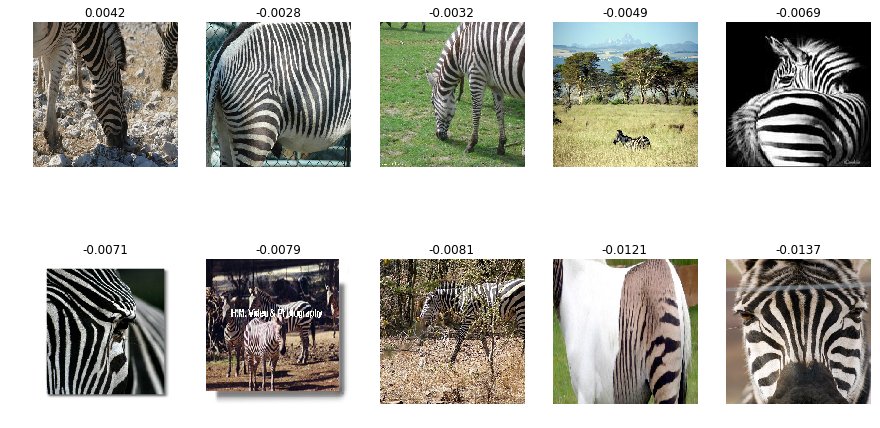

In [37]:
# plot by rank
w, h = 120, 120
fig = plt.figure(figsize=(15, 8))
columns, rows = 5, 2

start = 1

for i in range(1, columns*rows +1):
    img_path, cos = new_sorted_rank[start + i - 2]
    img = image.load_img(img_path, target_size=(299, 299))
    fig.add_subplot(rows, columns, i)
    plt.title(round(cos[0],4))
    plt.imshow(img)
    plt.axis('off')
plt.show()

## Perturb Activations

In [6]:
## first_part
tf.logging.set_verbosity(0)

to_mixed_9 = model.layers[279]
to_mixed_9.get_input_at(0)

mixed_9 = model.layers[280]
mixed_9.get_input_at(0)

first_part_endpoints = dict(
    input=model.inputs[0].name,
    input_tensor=model.inputs[0],
    logit=to_mixed_9.output[0].name,
    prediction=to_mixed_9.output[0].name,
    prediction_tensor=to_mixed_9.output[0],
)

first_part_model = tcav_model.KerasModelWrapper(sess, 
        label_path, [299, 299, 3], first_part_endpoints, 
        'InceptionV3_public', (-1, 1))

In [7]:
## second_part
tf.logging.set_verbosity(0)
mixed_9 = model.layers[280]
mixed_9.get_input_at(0)

second_part_endpoints = dict(
    input=mixed_9.name,
    input_tensor=mixed_9.input,
    logit=model.outputs[0].name,
    prediction=model.outputs[0].name,
    prediction_tensor=model.outputs[0],
)


second_part_model = tcav_model.KerasModelWrapper(sess, 
        label_path, [299, 299, 3], second_part_endpoints, 
        'InceptionV3_public', (-1, 1))

In [1418]:
## load CAV
class_1 = 'striped_sub_1'
class_2 = 'random500_1'
layer = 'mixed9'
lm_type = 'linear'

cav_name = class_1 + '-' + class_2 + '-' + layer + '-' + lm_type + '-0.1'
sub_path = 'cav_dir/' + cav_name + '.pkl'

path = os.path.join(working_dir, sub_path)
this_cav = cav.CAV.load_cav(path)

In [1419]:
cav_direction = this_cav.cavs[0]

In [1335]:
this_dir = 'concepts/lots_of_zebras/'
imgs = files_from_dir(this_dir)

In [1422]:
# perturb
num_idx = 150

alpha_list = np.linspace(0,20,5)

to_concept = class_1
acts_list = np.empty((num_idx,alpha_list.shape[0],131072))

z_list = np.empty((num_idx,alpha_list.shape[0]))
z_listt = np.empty((num_idx,alpha_list.shape[0]))

for idx in range(num_idx):
    for a_idx,this_alpha in enumerate(alpha_list):

        img_path = os.path.join(this_dir,imgs[idx])
        img = image.load_img(img_path, target_size=(299, 299))
        img_array = np.array(img)
        img_new_dims = np.expand_dims(img_array, axis=0)
        img_input = preprocess_input(img_new_dims)

        pred_1 = first_part_model.get_predictions(img_input)
        pred_1 = np.expand_dims(pred_1, axis=0)
        
        orig_dims = pred_1.shape
        pred_1_pert = np.add(np.reshape(pred_1,-1),cav_direction*this_alpha)
        pred_1_pert = pred_1_pert.reshape(orig_dims)
        pred_2 = second_part_model.get_predictions(pred_1_pert)
        dec = decode_predictions(pred_2, top=1000)

        z = None
        for d in dec[0]:
            if d[1] =='zebra':
                z = d[2]
            if d[1] == 'sorrel':
                z_1 = d[2]
        z_list[idx][a_idx] = z
        z_listt[idx][a_idx] = z_1
        acts_list[idx][a_idx] = pred_1_pert.reshape(-1)
        


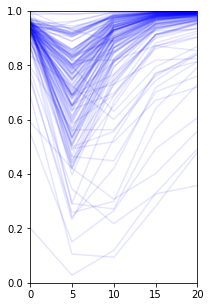

In [1426]:
fig = plt.figure(figsize=[3,5])


_ = plt.plot(alpha_list,z_list.T,color='b',alpha = .1)
#_ = plt.plot(alpha_list,z_listt.T,color='g',alpha = .1)

plt.xlim([0,20])
plt.ylim([0,1])
plt.savefig('new_figs/tmp.png',dpi=400,bbox_inches='tight')


In [545]:
### Plot with PCA
pca_components = pickle.load(open('pca/pca_components_mixed9.pkl', 'rb'))

In [555]:
x_orig = np.dot(acts_list[:,0],pca_components.T).T
x_new = np.dot(acts_list[:,9],pca_components.T).T



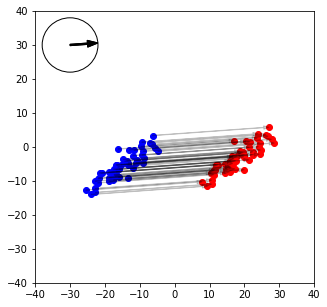

In [556]:
fig = plt.figure(figsize=[5,5])

this_cav = cav_direction
plt.scatter(x_orig[0], x_orig[1], color = 'b')
plt.scatter(x_new[0], x_new[1], color = 'r')

ax = plt.gca()

circ = plt.Circle((-30, 30), radius=8, edgecolor='black', facecolor='None')
ax.add_patch(circ)

#plt.scatter(cav_pca[0], cav_pca[1], color = 'b')


cav_pca = np.dot(pca_components, this_cav.T)
cav_norm = vector_norm(cav_pca)
cav_norm *= 8

arrow_start = [-30,30]
my_arrow = plt.arrow(arrow_start[0], arrow_start[1], cav_norm[0], cav_norm[1],width=.4,
                     length_includes_head=True,head_width=2,fc='k', ec=None)
ax.add_patch(my_arrow)

for i in range(x_orig.shape[1]):
    arrow_start = x_orig[:,i]
    dx,dy = x_new[:,i] - x_orig[:,i]
    
    my_arrow_3 = plt.arrow(arrow_start[0], arrow_start[1], dx, dy,width=.1,length_includes_head=True,head_width=1,fc='k', ec=None,alpha=.1)
    ax.add_patch(my_arrow_3)

xlim = plt.xlim([-40,40])
ylim = plt.ylim([-40,40])

fig_path = 'new_figs/tmp.png'

path = os.path.join(working_dir,fig_path)
plt.savefig(path,dpi=200)


In [557]:
layer = 'mixed9'

#my_class = 'zebra_50'
concept_p,concept_n = 'striped_sub_1','random500_0'
acts_p,_ = get_acts_for_concept(concept_p,layer)
acts_n,_ = get_acts_for_concept(concept_n,layer)
#_,acts_class = get_acts_for_concept(my_class,layer)

x = np.concatenate((acts_p,acts_n))
y = np.concatenate((np.zeros(50),np.ones(50)))
idx_array = np.arange(100)

x_train, x_test, y_train, y_test, idx_train, idx_test = train_test_split(x, y, idx_array, test_size=0.33, stratify=y,random_state=1,)

#cav_1 = make_orig_cav(x_train,y_train)

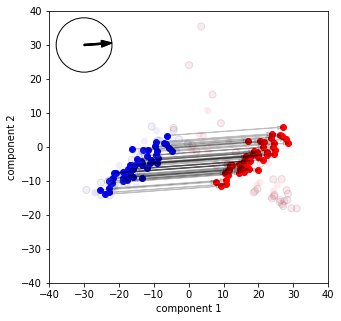

In [558]:
fig = plt.figure(figsize=[5,5])

ax = plt.gca()
plt.scatter(x_orig[0], x_orig[1], color = 'b')
plt.scatter(x_new[0], x_new[1], color = 'r')

for i in range(x_orig.shape[1]):
    arrow_start = x_orig[:,i]
    dx,dy = x_new[:,i] - x_orig[:,i]
    
    my_arrow_3 = plt.arrow(arrow_start[0], arrow_start[1], dx, dy,width=.1,length_includes_head=True,head_width=1,fc='k', ec=None,alpha=.1)
    ax.add_patch(my_arrow_3)

circ = plt.Circle((-30, 30), radius=8, edgecolor='black', facecolor='None')
ax.add_patch(circ)

#plt.scatter(cav_pca[0], cav_pca[1], color = 'b')


cav_pca = np.dot(pca_components, this_cav.T)
cav_norm = vector_norm(cav_pca)
cav_norm *= 8

arrow_start = [-30,30]
my_arrow = plt.arrow(arrow_start[0], arrow_start[1], cav_norm[0], cav_norm[1],width=.4,
                     length_includes_head=True,head_width=2,fc='k', ec=None)
ax.add_patch(my_arrow)


sPCA_comps = pca_components
#light_blue,light_red = '#b3b8fb','#f6889f'
blue1,red1='#6b73df','#ea385c'

train_embed = np.dot(sPCA_comps, x_train.T)
test_embed = np.dot(sPCA_comps, x_test.T)
c_train = [red1 if y == 0 else blue1 for y in y_train]
c_test = [red1 if y == 0 else blue1 for y in y_test]

plt.scatter(train_embed[0], train_embed[1], color = c_train, alpha = .1, edgecolor='black', s=50)
plt.scatter(test_embed[0], test_embed[1], color = c_test, alpha = .1, edgecolor=None, linewidths=0 ,s=50)

plt.xlabel('component 1')
plt.ylabel('component 2')

plt.xlim([-40,40])
plt.ylim([-40,40])
plt.savefig('new_figs/tmp.png',dpi=400)

In [183]:
this_dir = 'concepts/lots_of_zebras/'
imgs = files_from_dir(this_dir)

In [185]:
#imgs

In [310]:
# perturb
num_idx = 150

alpha_list = np.linspace(0,.0000000001,2)

to_concept = class_1
acts_list_2 = np.empty((num_idx,alpha_list.shape[0],131072))
z_list_2 = np.empty((num_idx,alpha_list.shape[0]))
for idx in range(num_idx):
    for a_idx,this_alpha in enumerate(alpha_list):

        img_path = os.path.join(this_dir,imgs[idx])
        img = image.load_img(img_path, target_size=(299, 299))
        img_array = np.array(img)
        img_new_dims = np.expand_dims(img_array, axis=0)
        img_input = preprocess_input(img_new_dims)

        pred_1 = first_part_model.get_predictions(img_input)
        pred_1 = np.expand_dims(pred_1, axis=0)

        pred_1_pert = np.add(np.reshape(pred_1,-1),cav_direction*this_alpha)
        pred_1_pert = pred_1_pert.reshape(1,8,8,2048)
        pred_2 = second_part_model.get_predictions(pred_1_pert)
        dec = decode_predictions(pred_2, top=1000)

        z = None
        for d in dec[0]:
            if d[1] =='zebra':
                z = d[2]
        z_list_2[idx][a_idx] = z
        acts_list_2[idx][a_idx] = pred_1_pert.reshape(-1)

In [351]:
img_path = os.path.join(this_dir,imgs[idx])
img = image.load_img(img_path, target_size=(299, 299))
img_array = np.array(img)
img_new_dims = np.expand_dims(img_array, axis=0)
img_input = preprocess_input(img_new_dims)
pred_1 = first_part_model.get_predictions(img_input)
pred_1 = np.expand_dims(pred_1, axis=0)
    
def z_from_alpha(alpha):
    
    pred_1_pert = np.reshape(pred_1,-1)
    pred_1_pert = pred_1_pert.reshape(1,8,8,2048)
    pred_2 = second_part_model.get_predictions(pred_1_pert)
    dec = decode_predictions(pred_2, top=1000)
    label = 'zebra'
    z1 = find_p(dec,label)

    pred_1_pert = np.add(np.reshape(pred_1,-1),cav_direction*alpha)
    pred_1_pert = pred_1_pert.reshape(1,8,8,2048)
    pred_2 = second_part_model.get_predictions(pred_1_pert)
    dec = decode_predictions(pred_2, top=1000)
    label = 'zebra'
    z2 = find_p(dec,label)
    
    return z2 - z1

In [329]:
z_from_alpha(1)

(0.9385825, 0.9385825)

In [508]:
def find_p(dec,label):
    z = None
    for d in dec[0]:
        if d[1] ==label:
            z = d[2]
    return z

In [309]:
np.linspace(0,.0000000001,2)

array([0.e+00, 1.e-10])

In [307]:
#z_list_2

In [317]:
from sympy import *

In [685]:
my_limit = limit(z_from_alpha(alpha), alpha, 0, dir="+")

In [686]:
my_limit

-0.000220060

In [687]:
alpha

0.05

In [405]:
def files_from_dir_ext(a_dir,ext):
    onlyfiles = [f for f in os.listdir(a_dir) if os.path.isfile(os.path.join(a_dir, f))]
    this_ext = [e for e in onlyfiles if ext in e.lower()]
    return this_ext

In [1326]:
# perturb
num_idx = 150

this_dir = 'concepts/lots_of_zebras/'
imgs = files_from_dir_ext(this_dir,'jp')
this_cav = cav_direction

to_concept = class_1
z_list_3 = np.empty(num_idx)
for idx in range(num_idx):
    img_path = os.path.join(this_dir,imgs[idx])
    img = image.load_img(img_path, target_size=(299, 299))
    img_array = np.array(img)
    img_new_dims = np.expand_dims(img_array, axis=0)
    img_input = preprocess_input(img_new_dims)
    pred_1 = first_part_model.get_predictions(img_input)
    pred_1 = np.expand_dims(pred_1, axis=0)
    
    pred_1_pert = np.add(np.reshape(pred_1,-1),0)
    pred_1_pert = pred_1_pert.reshape(1,8,8,2048)
    pred_2 = second_part_model.get_predictions(pred_1_pert)
    dec = decode_predictions(pred_2, top=1000)
    label = 'zebra'
    z1 = find_p(dec,label)

    z2 = limit((zz_from_alpha(alpha,pred_1,this_cav,label)-z1)/alpha,alpha,0, dir="+")
    
    z_list_3[idx] = z2

In [1327]:
idx

149

In [1328]:
#z_list_3

In [1329]:
(z_list_3 > 0).sum() / z_list_3.shape[0]

0.9533333333333334

In [594]:
#plt.hist(z_list_3)

In [688]:
def zz_from_alpha(alpha,pred_1,cav_direction,label):
    pred_1_pert = np.add(np.reshape(pred_1,-1),cav_direction*alpha)
    pred_1_pert = pred_1_pert.reshape(1,8,8,2048)
    pred_2 = second_part_model.get_predictions(pred_1_pert)
    dec = decode_predictions(pred_2, top=1000)
    z2 = find_p(dec,label)
    return z2

In [338]:
img_path

'concepts/lots_of_zebras/img458.jpg'

In [343]:
#acts_orig

-0.015300913723170202

In [ ]:
## does this match TCAV score??

In [1322]:
## class acts
concept_p = 'lots_of_zebras'
_,class_acts = get_acts_for_concept(concept_p,layer)

In [1323]:
this_cav = cav_direction
target_class = 'zebra'
bottleneck_name = layer
m = get_magnitude_list(target_class,this_cav,class_acts,bottleneck_name)


In [1324]:
(m < 0).sum() / m.shape[0]

0.98

In [1325]:
(a > 0).sum() / a.shape[0]

0.6466666666666666

In [899]:
a.argmax(),a.max()

(110, 0.001817028969526291)

In [900]:
a.argmin(),a.min()

(11, -2.142769517377019e-05)

In [992]:
np.where(a > .001)[0].shape[0] / a.shape[0]

0.9666666666666667

In [993]:
np.where(m > .001)[0].shape[0] / m.shape[0]

0.013333333333333334

In [1000]:
np.where(lion_m > .001)[0].shape[0] / lion_m.shape[0]

0.006666666666666667

In [1005]:
np.where(m > .001)

(array([ 62, 138]),)

In [1009]:
np.where(-m > .001)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
         27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  39,  40,
         41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
         54,  55,  56,  57,  58,  59,  60,  61,  63,  64,  65,  66,  67,
         68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,
         81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
         94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106,
        107, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
        121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
        134, 135, 136, 137, 139, 140, 141, 142, 143, 144, 145, 146, 147,
        148, 149]),)

In [1045]:
np.where(lion_a > .001)[0].shape[0] / lion_a.shape[0]

0.03333333333333333

In [1008]:
#m

In [ ]:
lion_a

In [1011]:
#lion_a = a
#lion_m = m
zebra_a = a
zebra_m = m

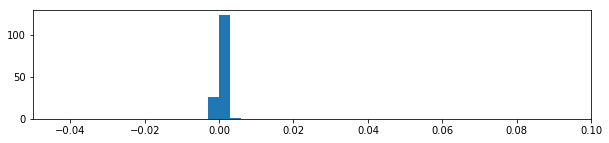

In [988]:
fig = plt.figure(figsize=[10,2])

xmin = -.05
xmax = .1
plt.xlim([xmin,xmax])
_ = plt.hist(lion_a,bins=51,range=(xmin,xmax))

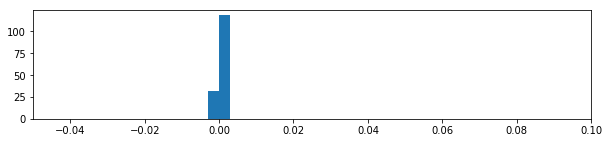

In [1098]:
fig = plt.figure(figsize=[10,2])

xmin = -.05
xmax = .1
plt.xlim([xmin,xmax])
_ = plt.hist(a,bins=51,range=(xmin,xmax))

In [906]:
idx = 11

In [907]:
imgs[idx]

'img132.jpg'

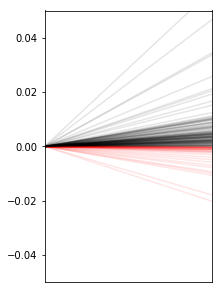

In [1462]:
fig = plt.figure(figsize=[3,5])

#plt.xlabel('component 1')
#plt.ylabel('component 2')
plt.xlim([0,1])
plt.ylim([-.05,.05])
plt.xticks([])

#a = lion_a

a = -m_1_s_1

c_list = ['black' if a_ > 0 else 'red' for a_  in a]

for z,c in zip(a,c_list):
    if c == 'black':
        alpha = .1
    else:
        alpha = .1
    #print(z)
    _ = plt.plot([0,1],[0,z], color=c,alpha = alpha)

plt.savefig('new_figs/tmp.png',dpi=400,bbox_inches='tight')

In [1375]:
147/150

0.98

In [1118]:
my_cav = this_cav.cavs[0]

In [781]:
img_path = 'concepts/lots_of_zebras/' + imgs[9]

In [1443]:
class_1 = 'striped_sub_1'
class_2 = 'random500_0'
layer = 'mixed9'
lm_type = 'linear'

cav_name = class_1 + '-' + class_2 + '-' + layer + '-' + lm_type + '-0.1'
sub_path = 'cav_dir/' + cav_name + '.pkl'

path = os.path.join(working_dir, sub_path)
this_cav = cav.CAV.load_cav(path)
my_cav = this_cav.cavs[0]
orig_cav = my_cav

concept_p = class_1
concept_n = class_2
layer = 'mixed9'
target_class = 'lots_of_zebras'

acts_p,_ = get_acts_for_concept(concept_p,layer)
acts_n,_ = get_acts_for_concept(concept_n,layer)
_,acts_class = get_acts_for_concept(target_class,layer)

x = np.concatenate((acts_p,acts_n))
y = np.concatenate((np.zeros(50),np.ones(50)))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y,random_state=1)

tmp_seeds = np.empty((100,my_cav.shape[0]))
for seed in range(100):
    tmp_seeds[seed] = make_orig_cav_seed(x_train,y_train,seed)
cav_1_s_1 = tmp_seeds.mean(axis=0)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y,random_state=3)

tmp_seeds = np.empty((100,my_cav.shape[0]))
for seed in range(100):
    tmp_seeds[seed] = make_orig_cav_seed(x_train,y_train,seed)
cav_1_s_2 = tmp_seeds.mean(axis=0)

concept_n = 'random500_1'
acts_n,_ = get_acts_for_concept(concept_n,layer)

x = np.concatenate((acts_p,acts_n))
y = np.concatenate((np.zeros(50),np.ones(50)))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y,random_state=1)

tmp_seeds = np.empty((100,my_cav.shape[0]))
for seed in range(100):
    tmp_seeds[seed] = make_orig_cav_seed(x_train,y_train,seed)
cav_2_s_1 = tmp_seeds.mean(axis=0)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y,random_state=3)

tmp_seeds = np.empty((100,my_cav.shape[0]))
for seed in range(100):
    tmp_seeds[seed] = make_orig_cav_seed(x_train,y_train,seed)
cav_2_s_2 = tmp_seeds.mean(axis=0)


In [1444]:
num_idx = 150

this_dir = 'concepts/lots_of_zebras/'
imgs = files_from_dir_ext(this_dir,'jp')

target_class = 'zebra'
my_cav = orig_cav

to_concept = class_1
a = np.empty(num_idx)
m = np.empty(num_idx)
#m_orig = np.empty(num_idx)
m_1_s_1 = np.empty(num_idx)
m_1_s_2 = np.empty(num_idx)
m_2_s_1 = np.empty(num_idx)
m_2_s_2 = np.empty(num_idx)

for idx in range(num_idx):
    img_path = os.path.join(this_dir,imgs[idx])
    img = prep2(img_path)
    this_img = np.expand_dims(img, axis=0)
    acts = get_acts_for_layer_new(layer,this_img)
    
    #class_id = 340
    class_id = mymodel.label_to_id(target_class)
    this_m = get_magnitude(acts, class_id,my_cav, bottleneck_name)
    m[idx] = this_m
    
    m_1_s_1[idx] = get_magnitude(acts, class_id,cav_1_s_1, bottleneck_name)
    m_1_s_2[idx] = get_magnitude(acts, class_id,cav_1_s_2, bottleneck_name)
    m_2_s_1[idx] = get_magnitude(acts, class_id,cav_2_s_1, bottleneck_name)
    m_2_s_2[idx] = get_magnitude(acts, class_id,cav_2_s_2, bottleneck_name)
    
    #this_m = get_magnitude(acts, class_id,orig_cav, bottleneck_name)
    #m_orig[idx] = this_m
    
    #pred_1 = acts
    #pred_1_pert = np.add(np.reshape(pred_1,-1),0)
    #pred_1_pert = pred_1_pert.reshape(1,8,8,2048)
    #pred_2 = second_part_model.get_predictions(pred_1_pert)
    #dec = decode_predictions(pred_2, top=1000)
    
    #z1 = find_p(dec,target_class)

    #z2 = limit((zz_from_alpha(alpha,pred_1,my_cav,target_class)-z1)/alpha,alpha,0, dir="+")
    
    #a[idx] = z2

In [1446]:
#np.where(a > 0)[0].shape[0] / a.shape[0]

In [1447]:
#np.where(a > .001)[0].shape[0] / a.shape[0]

In [1448]:
for m in [m_1_s_1,m_1_s_2,m_2_s_1,m_2_s_2]:
    print(np.where(m < 0)[0].shape[0] / m.shape[0])

0.7666666666666667
0.68
0.37333333333333335
0.3933333333333333


In [1464]:
#m_1_s_2 == m_2_s_2

In [1416]:
np.where(m < -.001)[0].shape[0] / m.shape[0]

0.03333333333333333

In [1369]:
#np.where(m_orig < 0)[0].shape[0] / m_orig.shape[0]

In [1290]:
#m_orig

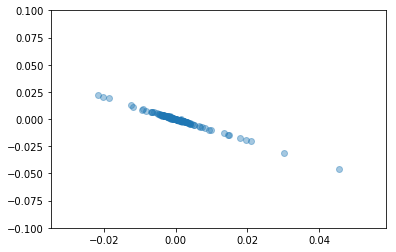

In [1109]:
plt.ylim([-.1,.1])
plt.ylim([-.1,.1])


plt.scatter(a,m,alpha = .4)

In [841]:
#this_cav

In [935]:
concept_p = 'lots_of_lions'
_,class_acts = get_acts_for_concept(concept_p,layer)

In [1010]:
#target_class
comp_tcav(target_class,my_cav,class_acts,bottleneck_name)

0.5771812080536913

In [937]:
target_class

'zebra'

In [112]:
import pandas as pd

In [113]:
columns = ['target_class','layer','concept_p','concept_n','split_seed','orig_score','marg_score','mean_score','log_score']
df = pd.DataFrame(columns = columns)
#pickle.dump(df,open('df_5x5.pkl', 'wb'))

In [1506]:
#pickle.dump(df,open('df_orig.pkl', 'wb'))

In [3]:
target_class = 'zebra_50'
target_class_name = 'zebra'
class_1_list = ['striped_sub_1']

bn_names = ['mixed0','mixed1','mixed2','mixed3','mixed4','mixed5','mixed6','mixed7','mixed8','mixed9','mixed10']
df = pickle.load(open('df_orig.pkl', 'rb'))
start_random = 0
num_random = 1
split_seed_list = [4]

for concept_p in class_1_list:
    for layer in  bn_names:
        for class_idx in range(start_random,start_random + num_random):
            for split_seed in split_seed_list:
                concept_n = 'random500_' + str(class_idx)
                #concept_n = 'N_' + str(class_idx)
                subset = df[(df['target_class']==target_class) & 
                        (df['layer']==layer) & 
                        (df['concept_p']==concept_p) &
                        (df['concept_n']==concept_n) &
                        (df['split_seed']==split_seed)]
                if len(subset) == 0:
                    print(f'running {target_class}, {layer}, {concept_p}, {concept_n}')

                    acts_p,_ = get_acts_for_concept(concept_p,layer)
                    acts_n,_ = get_acts_for_concept(concept_n,layer)
                    _,acts_class = get_acts_for_concept(target_class,layer)

                    x = np.concatenate((acts_p,acts_n))
                    y = np.concatenate((np.zeros(50),np.ones(50)))

                    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y,random_state=split_seed)

                    orig_cav = make_orig_cav(x_train,y_train)
                    orig_score = comp_tcav(target_class_name,orig_cav,acts_class,layer)

                    marg_seeds = np.empty((100,orig_cav.shape[0]))
                    for seed in range(100):
                        marg_seeds[seed] = make_orig_cav_seed(x_train,y_train,seed)
                    marg_cav = marg_seeds.mean(axis=0)
                    marg_score = comp_tcav(target_class_name,marg_cav,acts_class,layer)
                    
                    x_train_p_list,x_train_n_list =[],[]
                    for idx,a in enumerate(x_train):
                        if y_train[idx] == 1:
                            x_train_n_list.append(a)
                        else:
                            x_train_p_list.append(a)

                    x_train_p, x_train_n = np.array(x_train_p_list),np.array(x_train_n_list)

                    mu_p = (x_train_p).mean(axis=0)
                    mu_n = (x_train_n).mean(axis=0)
                    mean_cav = mu_p - mu_n
                    mean_score = comp_tcav(target_class_name,mean_cav,acts_class,layer)

                    #eta_p = np.median(x_train_p,axis=0)
                    #eta_n = np.median(x_train_n,axis=0)
                    #median_cav = eta_p - eta_n
                    #median_score = comp_tcav(target_class_name,median_cav,acts_class,layer)
                    
                    this_dict = {'target_class':target_class,
                                 'layer':layer,
                                 'split_seed':split_seed,
                                 'concept_p':concept_p,
                                 'concept_n':concept_n,
                                 'orig_score':orig_score,
                                 'marg_score':marg_score,
                                 'mean_score':mean_score,}
                                 #'median_score':median_score,}
                    df = df.append([this_dict])
                else:
                    print(f'already in df {target_class}, {layer}, {concept_p}, {concept_n}')
            
pickle.dump(df,open('df_orig.pkl', 'wb'))
print('### did write ###')

target_class = 'lion_50'
target_class_name = 'lion'
class_1_list = ['grassland_sub_1']

df = pickle.load(open('df_orig.pkl', 'rb'))

for concept_p in class_1_list:
    for layer in  bn_names:
        for class_idx in range(start_random,start_random + num_random):
            for split_seed in split_seed_list:
                concept_n = 'random500_' + str(class_idx)
                #concept_n = 'N_' + str(class_idx)
                subset = df[(df['target_class']==target_class) & 
                        (df['layer']==layer) & 
                        (df['concept_p']==concept_p) &
                        (df['concept_n']==concept_n) &
                        (df['split_seed']==split_seed)]
                if len(subset) == 0:
                    print(f'running {target_class}, {layer}, {concept_p}, {concept_n}')

                    acts_p,_ = get_acts_for_concept(concept_p,layer)
                    acts_n,_ = get_acts_for_concept(concept_n,layer)
                    _,acts_class = get_acts_for_concept(target_class,layer)

                    x = np.concatenate((acts_p,acts_n))
                    y = np.concatenate((np.zeros(50),np.ones(50)))

                    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y,random_state=split_seed)

                    orig_cav = make_orig_cav(x_train,y_train)
                    orig_score = comp_tcav(target_class_name,orig_cav,acts_class,layer)

                    marg_seeds = np.empty((100,orig_cav.shape[0]))
                    for seed in range(100):
                        marg_seeds[seed] = make_orig_cav_seed(x_train,y_train,seed)
                    marg_cav = marg_seeds.mean(axis=0)
                    marg_score = comp_tcav(target_class_name,marg_cav,acts_class,layer)
                    
                    x_train_p_list,x_train_n_list =[],[]
                    for idx,a in enumerate(x_train):
                        if y_train[idx] == 1:
                            x_train_n_list.append(a)
                        else:
                            x_train_p_list.append(a)

                    x_train_p, x_train_n = np.array(x_train_p_list),np.array(x_train_n_list)

                    mu_p = (x_train_p).mean(axis=0)
                    mu_n = (x_train_n).mean(axis=0)
                    mean_cav = mu_p - mu_n
                    mean_score = comp_tcav(target_class_name,mean_cav,acts_class,layer)

                    #eta_p = np.median(x_train_p,axis=0)
                    #eta_n = np.median(x_train_n,axis=0)
                    #median_cav = eta_p - eta_n
                    #median_score = comp_tcav(target_class_name,median_cav,acts_class,layer)
                    
                    this_dict = {'target_class':target_class,
                                 'layer':layer,
                                 'split_seed':split_seed,
                                 'concept_p':concept_p,
                                 'concept_n':concept_n,
                                 'orig_score':orig_score,
                                 'marg_score':marg_score,
                                 'mean_score':mean_score,}
                                 #'median_score':median_score,}
                    df = df.append([this_dict])
                else:
                    print(f'already in df {target_class}, {layer}, {concept_p}, {concept_n}')
            
pickle.dump(df,open('df_orig.pkl', 'wb'))
print('### did write ###')

target_class = 'cab_50'
target_class_name = 'cab'
class_1_list = ['yellow_sub_1']

df = pickle.load(open('df_orig.pkl', 'rb'))

for concept_p in class_1_list:
    for layer in  bn_names:
        for class_idx in range(start_random,start_random + num_random):
            for split_seed in split_seed_list:
                concept_n = 'random500_' + str(class_idx)
                #concept_n = 'N_' + str(class_idx)
                subset = df[(df['target_class']==target_class) & 
                        (df['layer']==layer) & 
                        (df['concept_p']==concept_p) &
                        (df['concept_n']==concept_n) &
                        (df['split_seed']==split_seed)]
                if len(subset) == 0:
                    print(f'running {target_class}, {layer}, {concept_p}, {concept_n}')

                    acts_p,_ = get_acts_for_concept(concept_p,layer)
                    acts_n,_ = get_acts_for_concept(concept_n,layer)
                    _,acts_class = get_acts_for_concept(target_class,layer)

                    x = np.concatenate((acts_p,acts_n))
                    y = np.concatenate((np.zeros(50),np.ones(50)))

                    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y,random_state=split_seed)

                    orig_cav = make_orig_cav(x_train,y_train)
                    orig_score = comp_tcav(target_class_name,orig_cav,acts_class,layer)

                    marg_seeds = np.empty((100,orig_cav.shape[0]))
                    for seed in range(100):
                        marg_seeds[seed] = make_orig_cav_seed(x_train,y_train,seed)
                    marg_cav = marg_seeds.mean(axis=0)
                    marg_score = comp_tcav(target_class_name,marg_cav,acts_class,layer)
                    
                    x_train_p_list,x_train_n_list =[],[]
                    for idx,a in enumerate(x_train):
                        if y_train[idx] == 1:
                            x_train_n_list.append(a)
                        else:
                            x_train_p_list.append(a)

                    x_train_p, x_train_n = np.array(x_train_p_list),np.array(x_train_n_list)

                    mu_p = (x_train_p).mean(axis=0)
                    mu_n = (x_train_n).mean(axis=0)
                    mean_cav = mu_p - mu_n
                    mean_score = comp_tcav(target_class_name,mean_cav,acts_class,layer)

                    #eta_p = np.median(x_train_p,axis=0)
                    #eta_n = np.median(x_train_n,axis=0)
                    #median_cav = eta_p - eta_n
                    #median_score = comp_tcav(target_class_name,median_cav,acts_class,layer)
                    
                    this_dict = {'target_class':target_class,
                                 'layer':layer,
                                 'split_seed':split_seed,
                                 'concept_p':concept_p,
                                 'concept_n':concept_n,
                                 'orig_score':orig_score,
                                 'marg_score':marg_score,
                                 'mean_score':mean_score,}
                                 #'median_score':median_score,}
                    df = df.append([this_dict])
                else:
                    print(f'already in df {target_class}, {layer}, {concept_p}, {concept_n}')
            
pickle.dump(df,open('df_orig.pkl', 'wb'))
print('### did write ###')


NameError: name 'pickle' is not defined

In [1526]:
target_class = 'zebra_50'
target_class_name = 'zebra'
class_1_list = ['striped_sub_1']

bn_names = ['mixed0','mixed1','mixed2','mixed3','mixed4','mixed5','mixed6','mixed7','mixed8','mixed9']#,'mixed10']
df = pickle.load(open('df_orig.pkl', 'rb'))
start_random = 4
num_random = 1
split_seed_list = [5]

for concept_p in class_1_list:
    for layer in  bn_names:
        for class_idx in range(start_random,start_random + num_random):
            for split_seed in split_seed_list:
                concept_n = 'random500_' + str(class_idx)
                #concept_n = 'N_' + str(class_idx)
                subset = df[(df['target_class']==target_class) & 
                        (df['layer']==layer) & 
                        (df['concept_p']==concept_p) &
                        (df['concept_n']==concept_n) &
                        (df['split_seed']==split_seed)]
                if len(subset) == 0:
                    print(f'running {target_class}, {layer}, {concept_p}, {concept_n}')

                    acts_p,_ = get_acts_for_concept(concept_p,layer)
                    acts_n,_ = get_acts_for_concept(concept_n,layer)
                    _,acts_class = get_acts_for_concept(target_class,layer)

                    x = np.concatenate((acts_p,acts_n))
                    y = np.concatenate((np.zeros(50),np.ones(50)))

                    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y,random_state=split_seed)

                    orig_cav = make_orig_cav(x_train,y_train)
                    orig_score = comp_tcav(target_class_name,orig_cav,acts_class,layer)

                    marg_seeds = np.empty((100,orig_cav.shape[0]))
                    for seed in range(100):
                        marg_seeds[seed] = make_orig_cav_seed(x_train,y_train,seed)
                    marg_cav = marg_seeds.mean(axis=0)
                    marg_score = comp_tcav(target_class_name,marg_cav,acts_class,layer)
                    
                    x_train_p_list,x_train_n_list =[],[]
                    for idx,a in enumerate(x_train):
                        if y_train[idx] == 1:
                            x_train_n_list.append(a)
                        else:
                            x_train_p_list.append(a)

                    x_train_p, x_train_n = np.array(x_train_p_list),np.array(x_train_n_list)

                    mu_p = (x_train_p).mean(axis=0)
                    mu_n = (x_train_n).mean(axis=0)
                    mean_cav = mu_p - mu_n
                    mean_score = comp_tcav(target_class_name,mean_cav,acts_class,layer)

                    #eta_p = np.median(x_train_p,axis=0)
                    #eta_n = np.median(x_train_n,axis=0)
                    #median_cav = eta_p - eta_n
                    #median_score = comp_tcav(target_class_name,median_cav,acts_class,layer)
                    
                    this_dict = {'target_class':target_class,
                                 'layer':layer,
                                 'split_seed':split_seed,
                                 'concept_p':concept_p,
                                 'concept_n':concept_n,
                                 'orig_score':orig_score,
                                 'marg_score':marg_score,
                                 'mean_score':mean_score,}
                                 #'median_score':median_score,}
                    df = df.append([this_dict])
                else:
                    print(f'already in df {target_class}, {layer}, {concept_p}, {concept_n}')
            
pickle.dump(df,open('df_orig.pkl', 'wb'))
print('### did write ###')

target_class = 'lion_50'
target_class_name = 'lion'
class_1_list = ['grassland_sub_1']

df = pickle.load(open('df_orig.pkl', 'rb'))

for concept_p in class_1_list:
    for layer in  bn_names:
        for class_idx in range(start_random,start_random + num_random):
            for split_seed in split_seed_list:
                concept_n = 'random500_' + str(class_idx)
                #concept_n = 'N_' + str(class_idx)
                subset = df[(df['target_class']==target_class) & 
                        (df['layer']==layer) & 
                        (df['concept_p']==concept_p) &
                        (df['concept_n']==concept_n) &
                        (df['split_seed']==split_seed)]
                if len(subset) == 0:
                    print(f'running {target_class}, {layer}, {concept_p}, {concept_n}')

                    acts_p,_ = get_acts_for_concept(concept_p,layer)
                    acts_n,_ = get_acts_for_concept(concept_n,layer)
                    _,acts_class = get_acts_for_concept(target_class,layer)

                    x = np.concatenate((acts_p,acts_n))
                    y = np.concatenate((np.zeros(50),np.ones(50)))

                    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y,random_state=split_seed)

                    orig_cav = make_orig_cav(x_train,y_train)
                    orig_score = comp_tcav(target_class_name,orig_cav,acts_class,layer)

                    marg_seeds = np.empty((100,orig_cav.shape[0]))
                    for seed in range(100):
                        marg_seeds[seed] = make_orig_cav_seed(x_train,y_train,seed)
                    marg_cav = marg_seeds.mean(axis=0)
                    marg_score = comp_tcav(target_class_name,marg_cav,acts_class,layer)
                    
                    x_train_p_list,x_train_n_list =[],[]
                    for idx,a in enumerate(x_train):
                        if y_train[idx] == 1:
                            x_train_n_list.append(a)
                        else:
                            x_train_p_list.append(a)

                    x_train_p, x_train_n = np.array(x_train_p_list),np.array(x_train_n_list)

                    mu_p = (x_train_p).mean(axis=0)
                    mu_n = (x_train_n).mean(axis=0)
                    mean_cav = mu_p - mu_n
                    mean_score = comp_tcav(target_class_name,mean_cav,acts_class,layer)

                    #eta_p = np.median(x_train_p,axis=0)
                    #eta_n = np.median(x_train_n,axis=0)
                    #median_cav = eta_p - eta_n
                    #median_score = comp_tcav(target_class_name,median_cav,acts_class,layer)
                    
                    this_dict = {'target_class':target_class,
                                 'layer':layer,
                                 'split_seed':split_seed,
                                 'concept_p':concept_p,
                                 'concept_n':concept_n,
                                 'orig_score':orig_score,
                                 'marg_score':marg_score,
                                 'mean_score':mean_score,}
                                 #'median_score':median_score,}
                    df = df.append([this_dict])
                else:
                    print(f'already in df {target_class}, {layer}, {concept_p}, {concept_n}')
            
pickle.dump(df,open('df_orig.pkl', 'wb'))
print('### did write ###')

target_class = 'cab_50'
target_class_name = 'cab'
class_1_list = ['yellow_sub_1']

df = pickle.load(open('df_orig.pkl', 'rb'))

for concept_p in class_1_list:
    for layer in  bn_names:
        for class_idx in range(start_random,start_random + num_random):
            for split_seed in split_seed_list:
                concept_n = 'random500_' + str(class_idx)
                #concept_n = 'N_' + str(class_idx)
                subset = df[(df['target_class']==target_class) & 
                        (df['layer']==layer) & 
                        (df['concept_p']==concept_p) &
                        (df['concept_n']==concept_n) &
                        (df['split_seed']==split_seed)]
                if len(subset) == 0:
                    print(f'running {target_class}, {layer}, {concept_p}, {concept_n}')

                    acts_p,_ = get_acts_for_concept(concept_p,layer)
                    acts_n,_ = get_acts_for_concept(concept_n,layer)
                    _,acts_class = get_acts_for_concept(target_class,layer)

                    x = np.concatenate((acts_p,acts_n))
                    y = np.concatenate((np.zeros(50),np.ones(50)))

                    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y,random_state=split_seed)

                    orig_cav = make_orig_cav(x_train,y_train)
                    orig_score = comp_tcav(target_class_name,orig_cav,acts_class,layer)

                    marg_seeds = np.empty((100,orig_cav.shape[0]))
                    for seed in range(100):
                        marg_seeds[seed] = make_orig_cav_seed(x_train,y_train,seed)
                    marg_cav = marg_seeds.mean(axis=0)
                    marg_score = comp_tcav(target_class_name,marg_cav,acts_class,layer)
                    
                    x_train_p_list,x_train_n_list =[],[]
                    for idx,a in enumerate(x_train):
                        if y_train[idx] == 1:
                            x_train_n_list.append(a)
                        else:
                            x_train_p_list.append(a)

                    x_train_p, x_train_n = np.array(x_train_p_list),np.array(x_train_n_list)

                    mu_p = (x_train_p).mean(axis=0)
                    mu_n = (x_train_n).mean(axis=0)
                    mean_cav = mu_p - mu_n
                    mean_score = comp_tcav(target_class_name,mean_cav,acts_class,layer)

                    #eta_p = np.median(x_train_p,axis=0)
                    #eta_n = np.median(x_train_n,axis=0)
                    #median_cav = eta_p - eta_n
                    #median_score = comp_tcav(target_class_name,median_cav,acts_class,layer)
                    
                    this_dict = {'target_class':target_class,
                                 'layer':layer,
                                 'split_seed':split_seed,
                                 'concept_p':concept_p,
                                 'concept_n':concept_n,
                                 'orig_score':orig_score,
                                 'marg_score':marg_score,
                                 'mean_score':mean_score,}
                                 #'median_score':median_score,}
                    df = df.append([this_dict])
                else:
                    print(f'already in df {target_class}, {layer}, {concept_p}, {concept_n}')
            
pickle.dump(df,open('df_orig.pkl', 'wb'))
print('### did write ###')


running zebra_50, mixed0, striped_sub_1, random500_4
running zebra_50, mixed1, striped_sub_1, random500_4
running zebra_50, mixed2, striped_sub_1, random500_4
running zebra_50, mixed3, striped_sub_1, random500_4
running zebra_50, mixed4, striped_sub_1, random500_4
running zebra_50, mixed5, striped_sub_1, random500_4
running zebra_50, mixed6, striped_sub_1, random500_4
running zebra_50, mixed7, striped_sub_1, random500_4
running zebra_50, mixed8, striped_sub_1, random500_4
running zebra_50, mixed9, striped_sub_1, random500_4
### did write ###
running lion_50, mixed0, grassland_sub_1, random500_4
running lion_50, mixed1, grassland_sub_1, random500_4
running lion_50, mixed2, grassland_sub_1, random500_4
running lion_50, mixed3, grassland_sub_1, random500_4
running lion_50, mixed4, grassland_sub_1, random500_4
running lion_50, mixed5, grassland_sub_1, random500_4
running lion_50, mixed6, grassland_sub_1, random500_4
running lion_50, mixed7, grassland_sub_1, random500_4
running lion_50, mix

In [114]:
#df

In [107]:
df = pickle.load(open('df_var1.pkl', 'rb'))


In [110]:
#df[df['concept_n']=='N_4']

In [435]:
columns = ['target_class','layer','concept_p','concept_n','split_seed','marg_score','mean_score','log_score']
df = pd.DataFrame(columns = columns)
#pickle.dump(df,open('df_5x5_500.pkl', 'wb'))

In [475]:
## CAV loop
source_dir = working_dir + '/concepts/'

target_class = 'lots_of_lions'
target_class_name = 'lion'

class_1_list = ['grassland_sub_1']

hparams = tf.contrib.training.HParams(model_type='linear', alpha=.1)

bn_names = ['mixed0','mixed1','mixed2','mixed3','mixed4','mixed5','mixed6','mixed7','mixed8','mixed9']#,'mixed10']
bn_names = ['mixed0','mixed9','mixed6']
bn_names = ['mixed6','mixed9']
bn_names = ['mixed8']

things_to_run = []
# target_class, target_class_name, concept_p, layer
'''
things_to_run.append(['lots_of_lions','lion','grassland_sub_1','mixed8'])
things_to_run.append(['lots_of_lions','lion','grassland_sub_1','mixed6'])
things_to_run.append(['lots_of_lions','lion','grassland_sub_1','mixed0'])
things_to_run.append(['cab','cab','yellow_sub_1','mixed0'])
things_to_run.append(['lots_of_zebras','zebra','striped_sub_1','mixed0'])
things_to_run.append(['lots_of_lions','lion','grassland_sub_1','mixed4'])
things_to_run.append(['cab','cab','yellow_sub_1','mixed4'])
things_to_run.append(['lots_of_zebras','zebra','striped_sub_1','mixed4'])
things_to_run.append(['lots_of_lions','lion','grassland_sub_1','mixed6'])
things_to_run.append(['cab','cab','yellow_sub_1','mixed6'])
things_to_run.append(['lots_of_zebras','zebra','striped_sub_1','mixed6'])
things_to_run.append(['lots_of_lions','lion','grassland_sub_1','mixed8'])
things_to_run.append(['cab','cab','yellow_sub_1','mixed8'])
things_to_run.append(['lots_of_zebras','zebra','striped_sub_1','mixed8'])
things_to_run.append(['lots_of_lions','lion','grassland_sub_1','mixed9'])
things_to_run.append(['cab','cab','yellow_sub_1','mixed9'])
things_to_run.append(['lots_of_zebras','zebra','striped_sub_1','mixed9'])
things_to_run.append(['lots_of_lions','lion','random500_21','mixed9'])
things_to_run.append(['cab','cab','random500_21','mixed9'])
things_to_run.append(['lots_of_zebras','zebra','random500_21','mixed9'])
things_to_run.append(['lots_of_lions','lion','random500_21','mixed6'])
things_to_run.append(['cab','cab','random500_21','mixed6'])
things_to_run.append(['lots_of_zebras','zebra','random500_21','mixed6'])
things_to_run.append(['lots_of_lions','lion','grassland_sub_1','mixed7'])
things_to_run.append(['cab','cab','yellow_sub_1','mixed7'])
things_to_run.append(['lots_of_zebras','zebra','striped_sub_1','mixed7'])
things_to_run.append(['ladybug','ladybug','dotted_sub_1','mixed8'])
things_to_run.append(['ladybug','ladybug','dotted_sub_1','mixed9'])
things_to_run.append(['ladybug','ladybug','green_sub_1','mixed8'])
things_to_run.append(['ladybug','ladybug','green_sub_1','mixed9'])

things_to_run.append(['miniskirt','miniskirt','male_sub_1','mixed9'])
things_to_run.append(['miniskirt','miniskirt','woman_sub_1','mixed9'])
things_to_run.append(['miniskirt','miniskirt','male_sub_1','mixed10'])
things_to_run.append(['miniskirt','miniskirt','woman_sub_1','mixed10'])

things_to_run.append(['lots_of_lions','lion','grassland_sub_1','mixed10'])
things_to_run.append(['cab','cab','yellow_sub_1','mixed10'])
things_to_run.append(['lots_of_zebras','zebra','striped_sub_1','mixed10'])

things_to_run.append(['lots_of_lions','lion','grassland_sub_1','mixed6'])
things_to_run.append(['cab','cab','yellow_sub_1','mixed6'])
things_to_run.append(['lots_of_zebras','zebra','striped_sub_1','mixed6'])
things_to_run.append(['lots_of_zebras','zebra','dotted_sub_1','mixed6'])

things_to_run.append(['ping_pong_ball','ping-pong_ball','white_sub_1','mixed9'])
things_to_run.append(['ping_pong_ball','ping-pong_ball','japanese_sub_1','mixed9'])
things_to_run.append(['ping_pong_ball','ping-pong_ball','ball_sub_1','mixed9'])

things_to_run.append(['lots_of_zebras','zebra','striped_sub_1','mixed4'])
things_to_run.append(['lots_of_zebras','zebra','dotted_sub_1','mixed4'])

things_to_run.append(['zebra_50','zebra','striped_sub_1','mixed0'])
things_to_run.append(['zebra_50','zebra','dotted_sub_1','mixed0'])

things_to_run.append(['zebra_50','zebra','striped_sub_1','mixed6'])
things_to_run.append(['zebra_50','zebra','dotted_sub_1','mixed6'])

things_to_run.append(['lion_50','lion','grassland_sub_1','mixed6'])
things_to_run.append(['lion_50','lion','ocean_sub_1','mixed6'])

things_to_run.append(['lion_50','lion','grassland_sub_1','mixed9'])
things_to_run.append(['lion_50','lion','ocean_sub_1','mixed9'])

things_to_run.append(['cab_50','cab','yellow_sub_1','mixed6'])
things_to_run.append(['cab_50','cab','blue_sub_1','mixed6'])

things_to_run.append(['aircraft_carrier_50','aircraft_carrier','ocean_sub_1','mixed10'])
things_to_run.append(['aircraft_carrier_50','aircraft_carrier','grassland_sub_1','mixed10'])

things_to_run.append(['aircraft_carrier_50','aircraft_carrier','ocean_sub_1','mixed8'])
things_to_run.append(['aircraft_carrier_50','aircraft_carrier','grassland_sub_1','mixed8'])

things_to_run.append(['aircraft_carrier_50','aircraft_carrier','ocean_sub_1','mixed9'])
things_to_run.append(['aircraft_carrier_50','aircraft_carrier','grassland_sub_1','mixed9'])

things_to_run.append(['ping_pong_ball','ping-pong_ball','ball_sub_1','mixed6'])

things_to_run.append(['lots_of_zebras','zebra','striped_sub_1','mixed7'])
things_to_run.append(['lots_of_zebras','zebra','dotted_sub_1','mixed7'])

things_to_run.append(['crossword','crossword_puzzle','grid_sub_1','mixed10'])
things_to_run.append(['crossword','crossword_puzzle','dotted_sub_1','mixed10'])

things_to_run.append(['lots_of_lions','lion','random500_21','mixed10'])
things_to_run.append(['cab','cab','random500_21','mixed10'])
things_to_run.append(['lots_of_zebras','zebra','random500_21','mixed10'])

things_to_run.append(['lots_of_lions','lion','noise_color','mixed10'])
things_to_run.append(['cab','cab','noise_color','mixed10'])
things_to_run.append(['lots_of_zebras','zebra','noise_color','mixed10'])
'''

things_to_run.append(['lots_of_zebras','zebra','striped_sub_2','mixed10'])
things_to_run.append(['lots_of_zebras','zebra','dotted_sub_2','mixed10'])

things_to_run.append(['crossword','crossword_puzzle','grid_sub_2','mixed10'])
things_to_run.append(['crossword','crossword_puzzle','dotted_sub_2','mixed10'])


num_random = 5

split_seed_list = [1,2,3,4,5]

for target_class, target_class_name, concept_p, layer in things_to_run:
    df = pickle.load(open('df_5x5.pkl', 'rb'))
    #df = pickle.load(open('df_5x5_500.pkl', 'rb'))
    for class_idx in range(num_random):
        for split_seed in split_seed_list:
        #split_seed = class_idx
            concept_n = 'random500_' + str(class_idx)
            #concept_n = 'N_' + str(class_idx)
            subset = df[(df['target_class']==target_class) & 
                    (df['layer']==layer) & 
                    (df['concept_p']==concept_p) &
                    (df['concept_n']==concept_n) &
                    (df['split_seed']==split_seed)]
            if len(subset) == 0:
                print(f'running {target_class}, {layer}, {concept_p}, {concept_n}')

                acts_p,_ = get_acts_for_concept(concept_p,layer)
                acts_n,_ = get_acts_for_concept(concept_n,layer)
                _,acts_class = get_acts_for_concept(target_class,layer)

                x = np.concatenate((acts_p,acts_n))
                #y = np.concatenate((np.zeros(50),np.ones(500)))
                y = np.concatenate((np.zeros(50),np.ones(50)))

                x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y,random_state=split_seed)

                #cav_1 = make_orig_cav(x_train,y_train)
                #score_1 = comp_tcav(target_class_name,cav_1,acts_class,layer)

                #cav_2_seeds = np.empty((100,size_dict[layer]))
                #for seed in range(100):
                #    cav_2_seeds[seed] = make_orig_cav_seed(x_train,y_train,seed)
                #cav_2 = cav_2_seeds.mean(axis=0)
                #marg_score = comp_tcav(target_class_name,cav_2,acts_class,layer)

                x_train_p_list,x_train_n_list =[],[]
                for idx,a in enumerate(x_train):
                    if y_train[idx] == 1:
                        x_train_p_list.append(a)
                    else:
                        x_train_n_list.append(a)

                x_train_p, x_train_n = np.array(x_train_p_list),np.array(x_train_n_list)

                mu_p = (x_train_p).mean(axis=0)
                mu_n = (x_train_n).mean(axis=0)
                cav_params = mu_n - mu_p
                mean_score = comp_tcav(target_class_name,cav_params,acts_class,layer)

                cav_params = make_log_cav(x_train,y_train)
                log_score = comp_tcav(target_class_name,cav_params,acts_class,layer)

                this_dict = {'target_class':target_class,
                             'layer':layer,
                             'split_seed':split_seed,
                             'concept_p':concept_p,
                             'concept_n':concept_n,
                             #'marg_score':marg_score,
                             'mean_score':mean_score,
                             'log_score':log_score}
                df = df.append([this_dict])
            else:
                print(f'already in df {target_class}, {layer}, {concept_p}, {concept_n}')

    pickle.dump(df,open('df_5x5.pkl', 'wb'))
    print('### did write ###')
pickle.dump(things_to_run,open('to_run.pkl','wb'))


running lots_of_zebras, mixed10, striped_sub_2, random500_0
running lots_of_zebras, mixed10, striped_sub_2, random500_0
running lots_of_zebras, mixed10, striped_sub_2, random500_0
running lots_of_zebras, mixed10, striped_sub_2, random500_0
running lots_of_zebras, mixed10, striped_sub_2, random500_0
running lots_of_zebras, mixed10, striped_sub_2, random500_1
running lots_of_zebras, mixed10, striped_sub_2, random500_1
running lots_of_zebras, mixed10, striped_sub_2, random500_1
running lots_of_zebras, mixed10, striped_sub_2, random500_1
running lots_of_zebras, mixed10, striped_sub_2, random500_1
running lots_of_zebras, mixed10, striped_sub_2, random500_2
running lots_of_zebras, mixed10, striped_sub_2, random500_2
running lots_of_zebras, mixed10, striped_sub_2, random500_2
running lots_of_zebras, mixed10, striped_sub_2, random500_2
running lots_of_zebras, mixed10, striped_sub_2, random500_2
running lots_of_zebras, mixed10, striped_sub_2, random500_3
running lots_of_zebras, mixed10, striped

In [451]:
columns = ['target_class','layer','concept_p','concept_n','split_seed','marg_score','mean_score','log_score']
df = pd.DataFrame(columns = columns)
#pickle.dump(df,open('df_5x2_500.pkl', 'wb'))

In [2]:
## CAV loop
source_dir = working_dir + '/concepts/'

target_class = 'lots_of_lions'
target_class_name = 'lion'

class_1_list = ['grassland_sub_1']

hparams = tf.contrib.training.HParams(model_type='linear', alpha=.1)

bn_names = ['mixed0','mixed1','mixed2','mixed3','mixed4','mixed5','mixed6','mixed7','mixed8','mixed9']#,'mixed10']
bn_names = ['mixed0','mixed9','mixed6']
bn_names = ['mixed6','mixed9']
bn_names = ['mixed8']

things_to_run = []
# target_class, target_class_name, concept_p, layer

#things_to_run.append(['zebra_50','zebra','striped_sub_1','mixed0'])
#things_to_run.append(['zebra_50','zebra','dotted_sub_1','mixed0'])

#things_to_run.append(['zebra_50','zebra','striped_sub_1','mixed6'])
#things_to_run.append(['zebra_50','zebra','dotted_sub_1','mixed6'])

#things_to_run.append(['lion_50','lion','grassland_sub_1','mixed6'])
#things_to_run.append(['lion_50','lion','ocean_sub_1','mixed6'])

#things_to_run.append(['lion_50','lion','grassland_sub_1','mixed9'])
#things_to_run.append(['lion_50','lion','ocean_sub_1','mixed9'])

#things_to_run.append(['cab_50','cab','yellow_sub_1','mixed6'])
#things_to_run.append(['cab_50','cab','blue_sub_1','mixed6'])

#things_to_run.append(['aircraft_carrier_50','aircraft_carrier','ocean_sub_1','mixed10'])
#things_to_run.append(['aircraft_carrier_50','aircraft_carrier','grassland_sub_1','mixed10'])

#things_to_run.append(['aircraft_carrier_50','aircraft_carrier','ocean_sub_1','mixed8'])
#things_to_run.append(['aircraft_carrier_50','aircraft_carrier','grassland_sub_1','mixed8'])

#things_to_run.append(['aircraft_carrier_50','aircraft_carrier','ocean_sub_1','mixed9'])
#things_to_run.append(['aircraft_carrier_50','aircraft_carrier','grassland_sub_1','mixed9'])

#things_to_run.append(['ping_pong_ball','ping-pong_ball','ball_sub_1','mixed6'])
#things_to_run.append(['aircraft_carrier_50','aircraft_carrier','grassland_sub_1','mixed9'])

things_to_run.append(['lots_of_zebras','zebra','striped_sub_1','mixed10'])

num_random = 5

split_seed_list = [1,2,3,4,5]

for target_class, target_class_name, concept_p, layer in things_to_run:
    df = pickle.load(open('df_5x2_500.pkl', 'rb'))
    for class_idx in range(num_random):
        for split_seed in split_seed_list:
        #split_seed = class_idx
            #concept_n = 'random500_' + str(class_idx)
            concept_n = 'N_' + str(class_idx)
            subset = df[(df['target_class']==target_class) & 
                    (df['layer']==layer) & 
                    (df['concept_p']==concept_p) &
                    (df['concept_n']==concept_n) &
                    (df['split_seed']==split_seed)]
            if len(subset) == 0:
                print(f'running {target_class}, {layer}, {concept_p}, {concept_n}')

                acts_p,_ = get_acts_for_concept(concept_p,layer)
                acts_n,_ = get_acts_for_concept(concept_n,layer)
                _,acts_class = get_acts_for_concept(target_class,layer)

                x = np.concatenate((acts_p,acts_n))
                y = np.concatenate((np.zeros(50),np.ones(500)))
                #y = np.concatenate((np.zeros(50),np.ones(50)))

                x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y,random_state=split_seed)

                #cav_1 = make_orig_cav(x_train,y_train)
                #score_1 = comp_tcav(target_class_name,cav_1,acts_class,layer)

                #cav_2_seeds = np.empty((100,size_dict[layer]))
                #for seed in range(100):
                #    cav_2_seeds[seed] = make_orig_cav_seed(x_train,y_train,seed)
                #cav_2 = cav_2_seeds.mean(axis=0)
                #marg_score = comp_tcav(target_class_name,cav_2,acts_class,layer)

                x_train_p_list,x_train_n_list =[],[]
                for idx,a in enumerate(x_train):
                    if y_train[idx] == 0:
                        x_train_p_list.append(a)
                    else:
                        x_train_n_list.append(a)

                x_train_p, x_train_n = np.array(x_train_p_list),np.array(x_train_n_list)

                mu_p = (x_train_p).mean(axis=0)
                mu_n = (x_train_n).mean(axis=0)
                cav_params = mu_p - mu_n
                mean_score = comp_tcav(target_class_name,cav_params,acts_class,layer)

                #cav_params = make_log_cav(x_train,y_train)
                #log_score = comp_tcav(target_class_name,cav_params,acts_class,layer)

                this_dict = {'target_class':target_class,
                             'layer':layer,
                             'split_seed':split_seed,
                             'concept_p':concept_p,
                             'concept_n':concept_n,
                             #'marg_score':marg_score,
                             'mean_score':mean_score,}
                             #'log_score':log_score}
                df = df.append([this_dict])
            else:
                print(f'already in df {target_class}, {layer}, {concept_p}, {concept_n}')

    pickle.dump(df,open('df_5x2_500.pkl', 'wb'))
    print('### did write ###')
pickle.dump(things_to_run,open('to_run_5x2.pkl','wb'))


NameError: name 'working_dir' is not defined

In [393]:
#df

In [449]:
#seed

In [375]:
#df1 = df.reset_index()
#df1.drop(index = [0,1,2,3,4],inplace=True)
#pickle.dump(df1,open('df_5x5.pkl', 'wb'))

In [414]:
len(things_to_run)

40

In [432]:
target_class = 'miniskirt'
concept_p = 'male_sub_1'
target_class = 'miniskirt'
concept_p = 'male_sub_1'
metrics = ['marg_score','log_score','mean_score']
layer = 'mixed10'

target_class, target_class_name, concept_p, layer = things_to_run[42]

subset = df[(df['target_class']==target_class) & 
            (df['layer']==layer) & (df['concept_p']==concept_p)]

for m in metrics:
    mean = round(subset[m].mean(),2)
    std = round(subset[m].std(),3)
    print(f'orig. mean of {mean} and std of {std} for {m}')

orig. mean of 0.58 and std of 0.367 for marg_score
orig. mean of 0.26 and std of 0.379 for log_score
orig. mean of 0.45 and std of 0.283 for mean_score


In [433]:
subset

,index,concept_n,concept_p,layer,log_score,marg_score,mean_score,split_seed,target_class
0,NaN,random500_0,noise_color,mixed10,0.926667,0.920000,0.606667,0,lots_of_zebras
0,NaN,random500_1,noise_color,mixed10,0.113333,0.013333,0.553333,1,lots_of_zebras
0,NaN,random500_2,noise_color,mixed10,0.006667,0.426667,0.053333,2,lots_of_zebras
0,NaN,random500_3,noise_color,mixed10,0.200000,0.700000,0.766667,3,lots_of_zebras
0,NaN,random500_4,noise_color,mixed10,0.060000,0.833333,0.286667,4,lots_of_zebras


## USING LOG

In [2223]:
columns = ['target_class','layer','concept_p','concept_n','split_seed','log_score']
df = pd.DataFrame(columns = columns)
#pickle.dump(df,open('df_log_balance.pkl', 'wb'))

In [2230]:
## CAV loop
source_dir = working_dir + '/concepts/'

target_class = 'lots_of_zebras'
target_class_name = 'zebra'
#class_1 = 'grassland_sub_1'

class_1_list = ['striped_sub_1']

hparams = tf.contrib.training.HParams(model_type='linear', alpha=.1)

bn_names = ['mixed0','mixed1','mixed2','mixed3','mixed4','mixed5','mixed6','mixed7','mixed8','mixed9']#,'mixed10']
#bn_names = ['mixed0','mixed9','mixed6']
bn_names = ['mixed9','mixed6']

df = pickle.load(open('df_log_balance.pkl', 'rb'))

num_random = 5

#split_seed_list = [1,2]
split_seed_list = [1,2,3,4,5,6,7,8,9,10]

for concept_p in class_1_list:
    for layer in  bn_names:
        for class_idx in range(num_random):
            for split_seed in split_seed_list:
                #concept_n = 'random500_' + str(class_idx)
                concept_n = 'N_' + str(class_idx)
                subset = df[(df['target_class']==target_class) & 
                        (df['layer']==layer) & 
                        (df['concept_p']==concept_p) &
                        (df['concept_n']==concept_n) &
                        (df['split_seed']==split_seed)]
                #if len(subset) < 10:
                if len(subset) == 0:
                    print(f'running {target_class}, {layer}, {concept_p}, {concept_n}')

                    acts_p,_ = get_acts_for_concept(concept_p,layer)
                    acts_n,_ = get_acts_for_concept(concept_n,layer)
                    _,acts_class = get_acts_for_concept(target_class,layer)

                    x = np.concatenate((acts_p,acts_n))
                    y = np.concatenate((np.zeros(50),np.ones(500)))
                    #y = np.concatenate((np.zeros(50),np.ones(50)))

                    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y,random_state=split_seed)

                    #lm = linear_model.LogisticRegression(class_weight={0:100000})
                    lm = linear_model.LogisticRegression(class_weight='balanced')
                    lm.fit(x_train, y_train)
                    cav_params = -lm.coef_[0]
        
                    log_score = comp_tcav(target_class_name,cav_params,acts_class,layer)

                    this_dict = {'target_class':target_class,
                                 'layer':layer,
                                 'split_seed':split_seed,
                                 'concept_p':concept_p,
                                 'concept_n':concept_n,
                                 'log_score':log_score,}
                    df = df.append([this_dict])
                else:
                    print(f'already in df {target_class}, {layer}, {concept_p}, {concept_n}')
            
pickle.dump(df,open('df_log_balance.pkl', 'wb'))
print('### did write ###')


## CAV loop
source_dir = working_dir + '/concepts/'

target_class = 'lots_of_lions'
target_class_name = 'lion'
#class_1 = 'grassland_sub_1'

class_1_list = ['grassland_sub_1']

hparams = tf.contrib.training.HParams(model_type='linear', alpha=.1)

bn_names = ['mixed0','mixed1','mixed2','mixed3','mixed4','mixed5','mixed6','mixed7','mixed8','mixed9']#,'mixed10']
#bn_names = ['mixed0','mixed9','mixed6']
bn_names = ['mixed9','mixed6']

df = pickle.load(open('df_log_balance.pkl', 'rb'))

num_random = 5

#split_seed_list = [1,2]
split_seed_list = [1,2,3,4,5,6,7,8,9,10]

for concept_p in class_1_list:
    for layer in  bn_names:
        for class_idx in range(num_random):
            for split_seed in split_seed_list:
                #concept_n = 'random500_' + str(class_idx)
                concept_n = 'N_' + str(class_idx)
                subset = df[(df['target_class']==target_class) & 
                        (df['layer']==layer) & 
                        (df['concept_p']==concept_p) &
                        (df['concept_n']==concept_n) &
                        (df['split_seed']==split_seed)]
                #if len(subset) < 10:
                if len(subset) == 0:
                    print(f'running {target_class}, {layer}, {concept_p}, {concept_n}')

                    acts_p,_ = get_acts_for_concept(concept_p,layer)
                    acts_n,_ = get_acts_for_concept(concept_n,layer)
                    _,acts_class = get_acts_for_concept(target_class,layer)

                    x = np.concatenate((acts_p,acts_n))
                    y = np.concatenate((np.zeros(50),np.ones(500)))
                    #y = np.concatenate((np.zeros(50),np.ones(50)))

                    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y,random_state=split_seed)

                    #lm = linear_model.LogisticRegression(class_weight={0:100000})
                    lm = linear_model.LogisticRegression(class_weight='balanced')
                    lm.fit(x_train, y_train)
                    cav_params = -lm.coef_[0]
        
                    log_score = comp_tcav(target_class_name,cav_params,acts_class,layer)

                    this_dict = {'target_class':target_class,
                                 'layer':layer,
                                 'split_seed':split_seed,
                                 'concept_p':concept_p,
                                 'concept_n':concept_n,
                                 'log_score':log_score,}
                    df = df.append([this_dict])
                else:
                    print(f'already in df {target_class}, {layer}, {concept_p}, {concept_n}')
            
pickle.dump(df,open('df_log_balance.pkl', 'wb'))
print('### did write ###')




already in df lots_of_zebras, mixed9, striped_sub_1, N_0
already in df lots_of_zebras, mixed9, striped_sub_1, N_0
running lots_of_zebras, mixed9, striped_sub_1, N_0
running lots_of_zebras, mixed9, striped_sub_1, N_0
running lots_of_zebras, mixed9, striped_sub_1, N_0
running lots_of_zebras, mixed9, striped_sub_1, N_0
running lots_of_zebras, mixed9, striped_sub_1, N_0
running lots_of_zebras, mixed9, striped_sub_1, N_0
running lots_of_zebras, mixed9, striped_sub_1, N_0
running lots_of_zebras, mixed9, striped_sub_1, N_0
already in df lots_of_zebras, mixed9, striped_sub_1, N_1
already in df lots_of_zebras, mixed9, striped_sub_1, N_1
running lots_of_zebras, mixed9, striped_sub_1, N_1
running lots_of_zebras, mixed9, striped_sub_1, N_1
running lots_of_zebras, mixed9, striped_sub_1, N_1
running lots_of_zebras, mixed9, striped_sub_1, N_1
running lots_of_zebras, mixed9, striped_sub_1, N_1
running lots_of_zebras, mixed9, striped_sub_1, N_1
running lots_of_zebras, mixed9, striped_sub_1, N_1
running

running lots_of_lions, mixed6, grassland_sub_1, N_0
running lots_of_lions, mixed6, grassland_sub_1, N_1
running lots_of_lions, mixed6, grassland_sub_1, N_1
running lots_of_lions, mixed6, grassland_sub_1, N_1
running lots_of_lions, mixed6, grassland_sub_1, N_1
running lots_of_lions, mixed6, grassland_sub_1, N_1
running lots_of_lions, mixed6, grassland_sub_1, N_1
running lots_of_lions, mixed6, grassland_sub_1, N_1
running lots_of_lions, mixed6, grassland_sub_1, N_1
running lots_of_lions, mixed6, grassland_sub_1, N_1
running lots_of_lions, mixed6, grassland_sub_1, N_1
running lots_of_lions, mixed6, grassland_sub_1, N_2
running lots_of_lions, mixed6, grassland_sub_1, N_2
running lots_of_lions, mixed6, grassland_sub_1, N_2
running lots_of_lions, mixed6, grassland_sub_1, N_2
running lots_of_lions, mixed6, grassland_sub_1, N_2
running lots_of_lions, mixed6, grassland_sub_1, N_2
running lots_of_lions, mixed6, grassland_sub_1, N_2
running lots_of_lions, mixed6, grassland_sub_1, N_2
running lots

In [2180]:
target_class ='lots_of_zebras'
layer = 'mixed6'
concept_p = 'random500_1'
split_seed = 7

concept_n = 'N_0'
concept_n = 'random500_1'

subset = df[(df['target_class']==target_class) & 
        (df['layer']==layer)]# &
        #(df['concept_n']==concept_n) & #]
        #(df['split_seed']==split_seed)]

In [2181]:
subset

,target_class,layer,concept_p,concept_n,split_seed,log_score
0,lots_of_zebras,mixed6,random500_21,random500_0,1,0.533333
0,lots_of_zebras,mixed6,random500_21,random500_0,2,0.460000
0,lots_of_zebras,mixed6,random500_21,random500_1,1,0.466667
0,lots_of_zebras,mixed6,random500_21,random500_1,2,0.426667
0,lots_of_zebras,mixed6,random500_22,random500_0,1,0.400000
0,lots_of_zebras,mixed6,random500_22,random500_0,2,0.400000
0,lots_of_zebras,mixed6,random500_22,random500_1,1,0.440000
0,lots_of_zebras,mixed6,random500_22,random500_1,2,0.353333
0,lots_of_zebras,mixed6,noise_color,random500_0,1,0.540000
0,lots_of_zebras,mixed6,noise_white,random500_0,1,0.640000


In [1951]:

lm = linear_model.LogisticRegression(class_weight={0:100000})
lm.fit(x_train, y_train)
this_cav = -lm.coef_[0]

log_score = comp_tcav(target_class_name,this_cav,acts_class,layer)

In [1952]:
log_score

0.72

In [1953]:
preds = lm.predict(x_test)

In [1954]:
from sklearn import metrics

In [1955]:
acc = metrics.precision_score(y_test,preds)

In [1956]:
acc

1.0

In [1957]:
preds.sum()

164.0

In [1958]:
y_test.sum()

165.0

## Max Perturb

In [52]:
## CAV loop
source_dir = working_dir + '/concepts/'

target_class = 'lots_of_zebras'
target_class_name = 'zebra'
#class_1 = 'grassland_sub_1'

class_1_list = ['striped_sub_1']

hparams = tf.contrib.training.HParams(model_type='linear', alpha=.1)

bn_names = ['mixed0','mixed1','mixed2','mixed3','mixed4','mixed5','mixed6','mixed7','mixed8','mixed9']#,'mixed10']
bn_names = ['mixed0','mixed9','mixed6']
bn_names = ['mixed6']

num_random = 1

split_seed_list = [1]

layer = bn_names[0]
split_seed = split_seed_list[0]
concept_n = 'random500_0'
concept_p = class_1_list[0]

acts_p,_ = get_acts_for_concept(concept_p,layer)
acts_n,_ = get_acts_for_concept(concept_n,layer)
_,acts_class = get_acts_for_concept(target_class,layer)

x = np.concatenate((acts_p,acts_n))
y = np.concatenate((np.zeros(50),np.ones(50)))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y,random_state=split_seed)


#cav_1 = make_orig_cav(x_train,y_train)
#score_1 = comp_tcav(target_class_name,cav_1,acts_class,layer)

#cav_2_seeds = np.empty((100,cav_1.shape[0]))
#for seed in range(100):
#    cav_2_seeds[seed] = make_orig_cav_seed(x_train,y_train,seed)
#cav_2 = cav_2_seeds.mean(axis=0)
#marg_score = comp_tcav(target_class_name,cav_2,acts_class,layer)
'''

x_train_p_list,x_train_n_list =[],[]
for idx,a in enumerate(x_train):
    if y_train[idx] == 1:
        x_train_p_list.append(a)
    else:
        x_train_n_list.append(a)

x_train_p, x_train_n = np.array(x_train_p_list),np.array(x_train_n_list)

mu_p = (x_train_p).mean(axis=0)
mu_n = (x_train_n).mean(axis=0)
#cav_3 = mu_n - mu_p
#mean_score = comp_tcav(target_class_name,cav_3,acts_class,layer)
'''

'\n\nx_train_p_list,x_train_n_list =[],[]\nfor idx,a in enumerate(x_train):\n    if y_train[idx] == 1:\n        x_train_p_list.append(a)\n    else:\n        x_train_n_list.append(a)\n\nx_train_p, x_train_n = np.array(x_train_p_list),np.array(x_train_n_list)\n\nmu_p = (x_train_p).mean(axis=0)\nmu_n = (x_train_n).mean(axis=0)\n#cav_3 = mu_n - mu_p\n#mean_score = comp_tcav(target_class_name,cav_3,acts_class,layer)\n'

In [90]:
#print(score_1,mean_score)
cav_params = make_log_cav(x_train,y_train)

In [91]:
cav_params.shape

(131072,)

In [28]:
#from sklearn.linear_model import SVC

In [54]:
toy_cavs_new = []
layer = 'mixed6'
is_mean = True
is_marg = False
is_svm = False
is_log = False

if is_mean:
    x_train_p_list,x_train_n_list =[],[]
    for idx_2,a in enumerate(x_train):
        if y_train[idx_2] == 0:
            x_train_p_list.append(a)
        else:
            x_train_n_list.append(a)

    x_train_p,x_train_n = None,None
    x_train_p, x_train_n = np.array(x_train_p_list),np.array(x_train_n_list)

    mu_p,mu_n = None,None
    mu_p = (x_train_p).mean(axis=0)
    mu_n = (x_train_n).mean(axis=0)
    #mu_p = np.median(x_train_p,axis=0)
    #mu_n = np.median(x_train_n,axis=0)
    cav_params = mu_p - mu_n

if is_marg:
    cav_seeds = np.empty((100,cav_params.shape[0]))
    for seed in range(100):
        cav_seeds[seed] = make_orig_cav_seed(x_train,y_train,seed)
    cav_params = cav_seeds.mean(axis=0)

if is_log:
    cav_params = make_log_cav(x_train,y_train)
if is_svm:
    cav_params = make_SVM_cav(x_train,y_train,.1)
original_CAV = cav_params

print(comp_tcav(target_class_name,cav_params,acts_class,layer))

for idx, x_point in enumerate(x_train):
    if y_train[idx]==0:
        x_train_new,y_train_new = None,None
        x_train_new = np.delete(x_train, idx, axis=0)
        y_train_new = np.delete(y_train, idx, axis=0)

        if is_mean:
            x_train_p_list,x_train_n_list =[],[]
            for idx_2,a in enumerate(x_train_new):
                if y_train_new[idx_2] == 0:
                    x_train_p_list.append(a)
                else:
                    x_train_n_list.append(a)

            x_train_p,x_train_n = None,None
            x_train_p, x_train_n = np.array(x_train_p_list),np.array(x_train_n_list)
            
            mu_p,mu_n = None,None
            mu_p = (x_train_p).mean(axis=0)
            mu_n = (x_train_n).mean(axis=0)
            #mu_p = np.median(x_train_p,axis=0)
            #mu_n = np.median(x_train_n,axis=0)
            cav_params = mu_p - mu_n
        
        if is_marg:
            cav_seeds = np.empty((100,cav_params.shape[0]))
            for seed in range(100):
                cav_seeds[seed] = make_orig_cav_seed(x_train_new,y_train_new,seed)
            cav_params = cav_seeds.mean(axis=0)

        
        if is_log:
            cav_params = make_log_cav(x_train_new,y_train_new)
        if is_svm:
            cav_params = make_SVM_cav(x_train_new,y_train_new,.1)
            
        new_score = comp_tcav(target_class_name,cav_params,acts_class,layer)
        cosine_sim = cosine_similarity(cav_params,original_CAV)
        toy_cavs_new.append([idx,cav_params,cosine_sim,new_score])
        
        print(cosine_sim) 
        print(idx)
    #if idx > 10:
    #    break

0.88
0.9993298000550785
0
0.9992824553820299
1
0.9992113139965096
3
0.9992232141200691
8
0.9993245735491644
10
0.9991687756753627
11
0.9993145197853833
14
0.999193246084419
16
0.9992134740361098
18
0.9992152954420825
20
0.9992251664937026
22
0.9992409982854327
26
0.9990657329243409
27
0.9991420304017771
30
0.9990430323695838
33
0.9988948310188637
37
0.9993592628872973
39
0.999288233817901
41
0.9990861468203263
42
0.9991378578036196
43
0.9990765023482814
45
0.999370276974098
46
0.999245638431785
47
0.9992949551679354
52
0.9992589128444241
53
0.9991625294275057
57
0.9991507847924475
58
0.999268985848445
59
0.9992051298695915
60
0.9992060463868762
61
0.999230382626202
62
0.9993418596975374
63
0.9993818619136368
64
0.9991427116113983
66


In [39]:
#cav_params = make_SVM_cav(x_train_new,y_train_new,.1)
lm = SVC(kernel = 'linear',random_state=3,C=.1)
lm.fit(x_train, y_train)

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=3,
  shrinking=True, tol=0.001, verbose=False)

In [40]:
lm.n_support_

array([20, 25], dtype=int32)

In [44]:
for idx,i in enumerate(lm.support_):
    if y_train[idx]==0:
        print(i)

1
3
11
33
41
42
47
59
62
2
7
15
17
24
29
36
50
54
55
56


In [46]:
np.where(cavs_sims==1)

(array([ 0,  3,  6, 10, 11, 13, 16, 19, 23, 24, 25, 29, 31, 32]),)

In [77]:
print(comp_tcav(target_class_name,original_CAV,acts_class,layer))

0.7666666666666667


In [69]:
acts_class.shape


(150, 8, 8, 2048)

In [55]:
this_var = toy_cavs_new
pickle.dump(this_var,open('pert_FINAL_mean.pkl','wb'))

In [2327]:
idx = 15

x_train_new = np.delete(x_train.copy(), idx, axis=0)
y_train_new = np.delete(y_train.copy(), idx, axis=0)

x_train_p_list,x_train_n_list =[],[]
for idx_2,a in enumerate(x_train_new):
    if y_train_new[idx_2] == 0:
        x_train_p_list.append(a)
    else:
        x_train_n_list.append(a)

x_train_p,x_train_n = None,None
x_train_p, x_train_n = np.array(x_train_p_list),np.array(x_train_n_list)

mu_p,mu_n = None,None
mu_p = (x_train_p).mean(axis=0)
mu_n = (x_train_n).mean(axis=0)
cav_params = mu_p-mu_n

In [2329]:
cavs_sims = np.array([a[2] for a in toy_cavs_new])
scores = np.array([a[3] for a in toy_cavs_new]) 

In [2334]:
dist_list = []
for idx_2,a in enumerate(x_train):
    if y_train[idx_2] == 0:
        dist = euclidean_distance(mu_orig,a)
        print(idx_2,dist)
        dist_list.append(dist)
    if idx_2 > 10:
        break
dist_array = np.array(dist_list)

0 133.28924646711988
1 137.62074878891892
3 145.14637007951242
8 143.34349877890932
10 138.39005618626138
11 149.804523121703


In [2323]:
x_train_p_list,x_train_n_list =[],[]
for idx_2,a in enumerate(x_train):
    if y_train[idx_2] == 0:
        x_train_p_list.append(a)
    else:
        x_train_n_list.append(a)

x_train_p, x_train_n = np.array(x_train_p_list),np.array(x_train_n_list)

mu_p = (x_train_p).mean(axis=0)
mu_n = (x_train_n).mean(axis=0)

#cav_params = get_L2(x_train_p) - get_L2(x_train_n)

cav_params = mu_p - mu_n
mu_orig = mu_p

In [ ]:
lm = linear_model.SGDClassifier(alpha=.1,random_state=seed)
lm.fit(x_train, y_train)
this_cav = -lm.coef_[0]

In [2194]:
cav_params = make_orig_cav_seed(x_train,y_train,3)

In [2201]:
lm = linear_model.SGDClassifier(alpha=.1,max_iter=10000)
lm.fit(x_train, y_train)
cav_params_1 = -lm.coef_[0]

In [ ]:
lm = linear_model.SGDClassifier(alpha=.1,max_iter=10000)
lm.fit(x_train, y_train)
this_cav = -lm.coef_[0]

In [38]:
(cavs_sims==1).sum()

14

In [ ]:
lm = 

In [1708]:
cav_seeds = np.empty((100,cav_params.shape[0]))
for seed in range(100):
    cav_seeds[seed] = make_orig_cav_seed(x_train,y_train,seed)
cav_params = cav_seeds.mean(axis=0)

original_CAV = cav_params
print(comp_tcav(target_class_name,original_CAV,acts_class,layer))

0.9


In [1701]:
#original_CAV

In [1736]:
cavs_sims = np.array([a[2] for a in toy_cavs_new])
scores = np.array([a[3] for a in toy_cavs_new]) 

In [2268]:
cavs_sims = np.array([cosine_similarity(a[1],original_CAV) for a in  toy_cavs_new])

In [33]:
pert_FINAL = toy_cavs_new
pickle.dump(pert_FINAL,open('pert_FINAL.pkl','wb'))

In [34]:
cavs_sims = np.array([a[2] for a in toy_cavs_new])
scores = np.array([a[3] for a in toy_cavs_new]) 

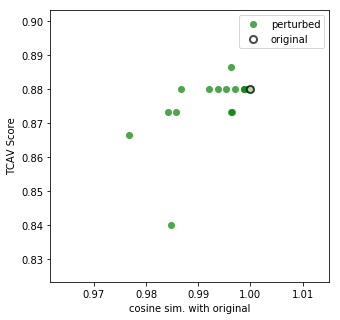

In [35]:
this = pickle.load(open('pert_FINAL.pkl','rb'))
#this = toy_cavs_new

cavs_sims = np.array([a[2] for a in this])
scores = np.array([a[3] for a in this]) 

fig = plt.figure(figsize=[5,5])

plt.scatter(cavs_sims,scores,c='g',alpha=.7,linewidths=0,s=50,label='perturbed')
plt.scatter(1,.88,c='w',alpha=.7,linewidths=2,s=50,edgecolor='k',label='original')

#my_xlim = plt.xlim([-110,165])
#my_ylim = plt.ylim([-50,225])

plt.xlabel('cosine sim. with original')
plt.ylabel('TCAV Score')
plt.legend()

plt.savefig('new_figs/tmp.png',dpi=300,bbox_inches='tight')

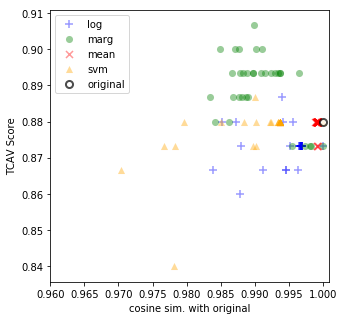

In [56]:
colors = ['b','g','r','orange']
files = ['pert_zebra_6_log','pert_zebra_6_marg','pert_zebra_6_mean','pert_zebra_6_svm']
#files = ['pert_zebra_6_mean']

labels = ['log','marg','mean','svm']
markers = ['+','o','x','^']

fig = plt.figure(figsize=[5,5])

for idx,f in enumerate(files):

    this = pickle.load(open(f+'.pkl','rb'))

    cavs_sims = np.array([a[2] for a in this])
    scores = np.array([a[3] for a in this]) 

    plt.scatter(cavs_sims,scores,c=colors[idx],alpha=.4,linewidths=0,s=50,label=labels[idx],marker=markers[idx])
    
plt.scatter(1,.88,c='w',alpha=.7,linewidths=2,s=50,edgecolor='k',label='original')

my_xlim = plt.xlim([.96,1.001])
#my_ylim = plt.ylim([-50,225])

plt.xlabel('cosine sim. with original')
plt.ylabel('TCAV Score')
plt.legend()

plt.savefig('new_figs/tmp.png',dpi=300,bbox_inches='tight')

In [54]:
f = 'pert_zebra_6_mean'
this = pickle.load(open(f+'.pkl','rb'))

In [55]:
np.array([a[2] for a in this])

array([0.9993298 , 0.99928246, 0.99921131, 0.99922321, 0.99932457,
       0.99916878, 0.99931452, 0.99919325, 0.99921347, 0.9992153 ,
       0.99922517, 0.999241  , 0.99906573, 0.99914203, 0.99904303,
       0.99889483, 0.99935926, 0.99928823, 0.99908615, 0.99913786,
       0.9990765 , 0.99937028, 0.99924564, 0.99929496, 0.99925891,
       0.99916253, 0.99915078, 0.99926899, 0.99920513, 0.99920605,
       0.99923038, 0.99934186, 0.99938186, 0.99914271])

In [30]:
#[a[3] for a in toy_cavs_new]

In [31]:
#np.where(cavs_sims > .3)

In [2247]:
pert_mean_6

In [2248]:
x_train[0]

array([2.26335049, 0.        , 2.90979767, ..., 0.        , 0.        ,
       0.24573904])

In [2249]:
mu_p

array([0.74618741, 0.75906916, 0.75350747, ..., 0.        , 0.39460079,
       0.31543479])

In [2258]:
x_train_p[0]

array([2.26335049, 0.        , 2.90979767, ..., 0.        , 0.        ,
       0.24573904])

In [18]:
#pert_mean_6[:5]

In [17]:
#i = 4
#for i in range(66):
#    if y_train[i] == 0:
#        d = euclidean_distance(x_train[i],mu_p)
#        print(d,y_train[i])

In [84]:
lm = SVC(kernel = 'linear',random_state=3,C=.1)
lm.fit(x_train, y_train)
this_cav = -lm.coef_[0]

In [85]:
lm.n_support_

array([20, 25], dtype=int32)

In [88]:
lm.support_

array([ 1,  3, 10, 11, 16, 18, 20, 27, 33, 37, 41, 42, 45, 46, 47, 58, 59,
       60, 62, 66,  2,  4,  7,  9, 12, 13, 15, 17, 19, 21, 24, 25, 28, 29,
       31, 32, 34, 36, 40, 50, 51, 54, 55, 56, 65], dtype=int32)

In [1711]:
x_train.shape

(67, 221952)

In [1712]:
min_idx = cavs_sims.argmin()
min_idx

26

In [1713]:
toy_cavs_new[min_idx]

[58, array([ 0.08780051,  0.0238153 ,  0.009008  , ..., -0.02849856,
        -0.04232797,  0.03220189]), 0.2618728038019292, 0.9]

In [1714]:
idx

66

In [1673]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(x_train)
pca_c = pca.components_

In [1674]:
#pca_c

In [1675]:
pca_c.shape

(2, 221952)

In [1676]:
train_embed = np.dot(x_train_new,pca_c.T)

In [1677]:
train_embed[0]

array([-84.45783946,  71.89198424])

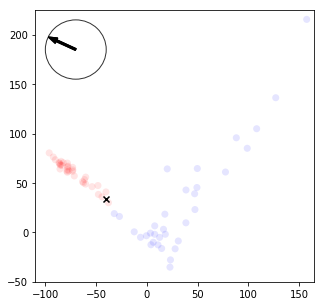

In [1717]:
i = min_idx
cav_params = toy_cavs_new[i][1]
idx = toy_cavs_new[i][0]

#cav_params = original_CAV

x_train_new = np.delete(x_train, idx, axis=0)
y_train_new = np.delete(y_train, idx, axis=0)

light_blue, light_red = '#b3b8fb', '#f6889f'
fig = plt.figure(figsize=[5,5])

# train
color_train = ['red' if y == 0 else 'blue' for y in y_train_new]
train_embed = np.dot(x_train_new,pca_c.T)
plt.scatter(train_embed[:,0], train_embed[:,1], color = color_train, alpha = .1,linewidths=0,s=50)

old_train_embed = np.dot(x_train,pca_c.T)
plt.scatter(old_train_embed[idx][0], old_train_embed[idx][1], color = 'k', alpha = 1, marker='x')

x0,x1 = -70,185
ax = plt.gca()
radius = 30
circ = plt.Circle((x0,x1), radius=radius, edgecolor='black', facecolor='white',zorder=4,alpha=.8)
ax.add_patch(circ)

cav_pca = np.dot(cav_params,pca_c.T)
arrow_start = [x0,x1]
cav_norm = vec_norm(cav_pca) * radius
my_arrow = plt.arrow(arrow_start[0], arrow_start[1], cav_norm[0], cav_norm[1],width=2,length_includes_head=True,head_width=6,fc='k', ec=None, alpha = 1,zorder=5)
a0 = ax.add_patch(my_arrow)

cav_orig = original_CAV
cav_pca = np.dot(cav_orig,pca_c.T)
arrow_start = [x0,x1]
cav_norm_1 = vec_norm(cav_pca) * radius
my_arrow = plt.arrow(arrow_start[0], arrow_start[1], cav_norm_1[0], cav_norm_1[1],width=2,length_includes_head=True,head_width=6,fc='k', ec=None, alpha = .1,zorder=5)
a0 = ax.add_patch(my_arrow)

#c0,c1 = lm.coef_[0]
#b = lm.intercept_
#x_ = np.linspace(-10,10,100)
#y_ = (-c0/c1)*x_-b/c1
#plt.plot(x_, y_, 'k')

#plt.xlabel('Train/test split seed')
#plt.ylabel('TCAV Score')

my_xlim = plt.xlim([-110,165])
my_ylim = plt.ylim([-50,225])

#_,_ = plt.xticks([], []),plt.yticks([], [])
plt.savefig('new_figs/tmo.png',dpi=200)

In [1672]:
cav_norm

array([-11.61834588, -27.65888716])

In [1637]:
cav_norm_1

array([-28.66827882,   8.83910568])

In [1618]:
cosine_similarity(cav_params,cav_orig)

0.20221238587556115

## score == 0

In [2122]:
source_dir = working_dir + '/concepts/'

target_class = 'lots_of_lions'
target_class_name = 'lion'
#class_1 = 'grid_sub_1'

class_1_list = ['random500_3']

hparams = tf.contrib.training.HParams(model_type='linear', alpha=.1)

bn_names = ['mixed0','mixed1','mixed2','mixed3','mixed4','mixed5','mixed6','mixed7','mixed8','mixed9']#,'mixed10']
#bn_names = ['mixed0','mixed9','mixed6']
#bn_names = ['mixed10']

num_random = 1

split_seed_list = [1]

for layer in bn_names:
#layer = bn_names[0]
    split_seed = split_seed_list[0]
    concept_n = 'random500_0'
    concept_p = class_1_list[0]

    acts_p,_ = get_acts_for_concept(concept_p,layer)
    acts_n,_ = get_acts_for_concept(concept_n,layer)
    _,acts_class = get_acts_for_concept(target_class,layer)

    x = np.concatenate((acts_p,acts_n))
    y = np.concatenate((np.zeros(50),np.ones(50)))

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y,random_state=split_seed)
    
    lm = linear_model.LogisticRegression()
    lm.fit(x_train, y_train)
    cav_params = -lm.coef_[0]
    
    preds = lm.predict(x_test)
    acc = metrics.accuracy_score(y_test,preds)
    score = comp_tcav(target_class_name,cav_params,acts_class,layer)
    print(layer,score,acc)

mixed0 0.4533333333333333 0.45454545454545453
mixed1 0.44 0.45454545454545453
mixed2 0.4 0.5151515151515151
mixed3 0.42 0.48484848484848486
mixed4 0.42 0.45454545454545453
mixed5 0.41333333333333333 0.48484848484848486
mixed6 0.41333333333333333 0.5454545454545454
mixed7 0.5333333333333333 0.45454545454545453
mixed8 0.47333333333333333 0.5454545454545454
mixed9 0.5666666666666667 0.45454545454545453


In [2112]:
cav_params = make_log_cav(x_train,y_train)
original_CAV = cav_params
print(comp_tcav(target_class_name,original_CAV,acts_class,layer))

0.11333333333333333


## REMOVE random 10

In [361]:
source_dir = working_dir + '/concepts/'

target_class = 'lots_of_zebras'
#target_class = 'lots_of_lions'
#target_class_name = 'lion'
target_class_name = 'zebra'

#class_1 = 'grid_sub_1'

#class_1_list = ['random500_21']
class_1_list = ['striped_sub_1']


hparams = tf.contrib.training.HParams(model_type='linear', alpha=.1)

bn_names = ['mixed0','mixed1','mixed2','mixed3','mixed4','mixed5','mixed6','mixed7','mixed8','mixed9']#,'mixed10']
bn_names = ['mixed0','mixed9','mixed6']
bn_names = ['mixed8']

num_random = 1

split_seed_list = [1]

layer = bn_names[0]
split_seed = split_seed_list[0]
concept_n = 'random500_0'
concept_p = class_1_list[0]

acts_p,_ = get_acts_for_concept(concept_p,layer)
acts_n,_ = get_acts_for_concept(concept_n,layer)
_,acts_class = get_acts_for_concept(target_class,layer)

x = np.concatenate((acts_p,acts_n))
y = np.concatenate((np.zeros(50),np.ones(50)))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y,random_state=split_seed)

In [362]:
p_idx = []
for idx, x_point in enumerate(x_train):
    if y_train[idx]==0:
        p_idx.append(idx)

In [365]:
n = 40
ext = 'zebra_8_marg_svm'

is_mean = False
is_marg = False
is_svm = True
is_log = False

if is_mean:
    x_train_p_list,x_train_n_list =[],[]
    for idx_2,a in enumerate(x_train):
        if y_train[idx_2] == 0:
            x_train_p_list.append(a)
        else:
            x_train_n_list.append(a)

    x_train_p,x_train_n = None,None
    x_train_p, x_train_n = np.array(x_train_p_list),np.array(x_train_n_list)

    mu_p,mu_n = None,None
    mu_p = (x_train_p).mean(axis=0)
    mu_n = (x_train_n).mean(axis=0)
    cav_params = mu_p - mu_n

if is_marg:
    cav_seeds = np.empty((100,size_dict[layer]))
    for seed in range(100):
        cav_seeds[seed] = make_orig_cav_seed(x_train,y_train,seed)
    cav_params = cav_seeds.mean(axis=0)

if is_log:
    cav_params = make_log_cav(x_train,y_train)
if is_svm:
    cav_params = make_SVM_cav(x_train,y_train,.1)
original_CAV = cav_params

print(comp_tcav(target_class_name,original_CAV,acts_class,layer))

try:
    remove_10 = pickle.load(open(f'remove_10_{ext}.pkl','rb'))
except:
    remove_10 = []

for i in range(n):
    np.random.shuffle(p_idx)
    x_train_new = np.delete(x_train, p_idx[:10], axis=0)
    y_train_new = np.delete(y_train, p_idx[:10], axis=0)
    
    if is_mean:
        x_train_p_list,x_train_n_list =[],[]
        for idx_2,a in enumerate(x_train_new):
            if y_train_new[idx_2] == 0:
                x_train_p_list.append(a)
            else:
                x_train_n_list.append(a)

        x_train_p,x_train_n = None,None
        x_train_p, x_train_n = np.array(x_train_p_list),np.array(x_train_n_list)

        mu_p,mu_n = None,None
        mu_p = (x_train_p).mean(axis=0)
        mu_n = (x_train_n).mean(axis=0)
        cav_params = mu_p - mu_n

    if is_marg:
        cav_seeds = np.empty((100,size_dict[layer]))
        for seed in range(100):
            cav_seeds[seed] = make_orig_cav_seed(x_train_new,y_train_new,seed)
        cav_params = cav_seeds.mean(axis=0)

    if is_log:
        cav_params = make_log_cav(x_train_new,y_train_new)
    if is_svm:
        cav_params = make_SVM_cav(x_train_new,y_train_new,.1)
    new_score = comp_tcav(target_class_name,cav_params,acts_class,layer)

    cosine_sim = cosine_similarity(cav_params,original_CAV)
    remove_10.append([idx,cav_params,cosine_sim,new_score])
    print(i)

pickle.dump(remove_10,open(f'remove_10_{ext}.pkl','wb'))


try:
    remove_20 = pickle.load(open(f'remove_20_{ext}.pkl','rb'))
except:
    remove_20 = []

for i in range(n+5):
    np.random.shuffle(p_idx)
    x_train_new = np.delete(x_train, p_idx[:20], axis=0)
    y_train_new = np.delete(y_train, p_idx[:20], axis=0)
    
    if is_mean:
        x_train_p_list,x_train_n_list =[],[]
        for idx_2,a in enumerate(x_train_new):
            if y_train_new[idx_2] == 0:
                x_train_p_list.append(a)
            else:
                x_train_n_list.append(a)

        x_train_p,x_train_n = None,None
        x_train_p, x_train_n = np.array(x_train_p_list),np.array(x_train_n_list)

        mu_p,mu_n = None,None
        mu_p = (x_train_p).mean(axis=0)
        mu_n = (x_train_n).mean(axis=0)
        cav_params = mu_p - mu_n

    if is_marg:
        cav_seeds = np.empty((100,size_dict[layer]))
        for seed in range(100):
            cav_seeds[seed] = make_orig_cav_seed(x_train_new,y_train_new,seed)
        cav_params = cav_seeds.mean(axis=0)

    if is_log:
        cav_params = make_log_cav(x_train_new,y_train_new)
    if is_svm:
        cav_params = make_SVM_cav(x_train_new,y_train_new,.1)
    new_score = comp_tcav(target_class_name,cav_params,acts_class,layer)

    cosine_sim = cosine_similarity(cav_params,original_CAV)
    remove_20.append([idx,cav_params,cosine_sim,new_score])
    print(i)

pickle.dump(remove_20,open(f'remove_20_{ext}.pkl','wb'))


try:
    remove_30 = pickle.load(open(f'remove_30_{ext}.pkl','rb'))
except:
    remove_30 = []

for i in range(n):
    np.random.shuffle(p_idx)
    x_train_new = np.delete(x_train, p_idx[:30], axis=0)
    y_train_new = np.delete(y_train, p_idx[:30], axis=0)
    
    if is_mean:
        x_train_p_list,x_train_n_list =[],[]
        for idx_2,a in enumerate(x_train_new):
            if y_train_new[idx_2] == 0:
                x_train_p_list.append(a)
            else:
                x_train_n_list.append(a)

        x_train_p,x_train_n = None,None
        x_train_p, x_train_n = np.array(x_train_p_list),np.array(x_train_n_list)

        mu_p,mu_n = None,None
        mu_p = (x_train_p).mean(axis=0)
        mu_n = (x_train_n).mean(axis=0)
        cav_params = mu_p - mu_n

    if is_marg:
        cav_seeds = np.empty((100,size_dict[layer]))
        for seed in range(100):
            cav_seeds[seed] = make_orig_cav_seed(x_train_new,y_train_new,seed)
        cav_params = cav_seeds.mean(axis=0)

    if is_log:
        cav_params = make_log_cav(x_train_new,y_train_new)
    if is_svm:
        cav_params = make_SVM_cav(x_train_new,y_train_new,.1)
    new_score = comp_tcav(target_class_name,cav_params,acts_class,layer)

    cosine_sim = cosine_similarity(cav_params,original_CAV)
    remove_30.append([idx,cav_params,cosine_sim,new_score])
    print(i)

pickle.dump(remove_30,open(f'remove_30_{ext}.pkl','wb'))



0.9
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


In [139]:
cav_params = make_log_cav(x_train,y_train)
original_CAV = cav_params

In [141]:
cosine_sim = cosine_similarity(cav_params,original_CAV)

In [142]:
cosine_sim

1.0

In [156]:
remove = pickle.load(open(f'remove_10_{ext}.pkl','rb'))

In [157]:
remove_new = []
for idx,cav_params,cos_sim,score in remove:
    #print(cos_sim)
    new_c = cosine_similarity(cav_params,original_CAV)
    remove_new.append([idx,cav_params,new_c,score])

In [158]:
pickle.dump(remove_new,open(f'remove_10_{ext}_new.pkl','wb'))

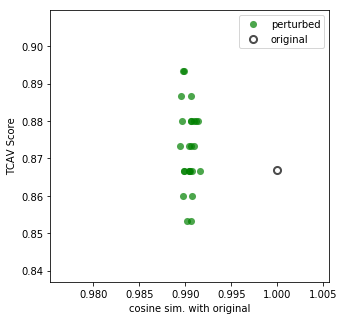

In [2316]:
this = remove_10

cavs_sims = np.array([a[2] for a in this])
scores = np.array([a[3] for a in this]) 

fig = plt.figure(figsize=[5,5])

plt.scatter(cavs_sims,scores,c='g',alpha=.7,linewidths=0,s=50,label='perturbed')
plt.scatter(1,.867,c='w',alpha=.7,linewidths=2,s=50,edgecolor='k',label='original')

#my_xlim = plt.xlim([-110,165])
#my_ylim = plt.ylim([-50,225])

plt.xlabel('cosine sim. with original')
plt.ylabel('TCAV Score')
plt.legend()

plt.savefig('new_figs/tmp.png',dpi=300,bbox_inches='tight')

In [314]:
x_train_p_list,x_train_n_list =[],[]
for idx_2,a in enumerate(x_train):
    if y_train[idx_2] == 0:
        x_train_p_list.append(a)
    else:
        x_train_n_list.append(a)

x_train_p,x_train_n = None,None
x_train_p, x_train_n = np.array(x_train_p_list),np.array(x_train_n_list)

mu_p,mu_n = None,None
mu_p = (x_train_p).mean(axis=0)
mu_n = (x_train_n).mean(axis=0)
cav_params = mu_p-mu_n
    
#cav_params = make_log_cav(x_train,y_train)
original_CAV = cav_params

In [352]:
cosip_idx)
x_train_new = np.delete(x_train, p_idx[:30], axis=0)
y_train_new = np.delete(y_train, p_idx[:30], axis=0)

x_train_p_list,x_train_n_list =[],[]
for idx_2,a in enumerate(x_train_new):
    if y_train_new[idx_2] == 0:
        x_train_p_list.append(a)
    else:
        x_train_n_list.append(a)

x_train_p,x_train_n = None,None
x_train_p, x_train_n = np.array(x_train_p_list),np.array(x_train_n_list)

mu_p,mu_n = None,None
mu_p = (x_train_p).mean(axis=0)
mu_n = (x_train_n).mean(axis=0)
cav_params = mu_p-mu_n

#cav_params = make_log_cav(x_train_new,y_train_new)

new_score = comp_tcav(target_class_name,cav_params,acts_class,layer)

cosine_sim = cosine_similarity(cav_params,original_CAV)
xx = [p_idx[:30],cav_params,cosine_sim,new_score]

In [353]:
#xx

In [354]:
pca_c = pickle.load(open('spca_comps.pkl','rb'))

In [355]:
#y_train[idx]

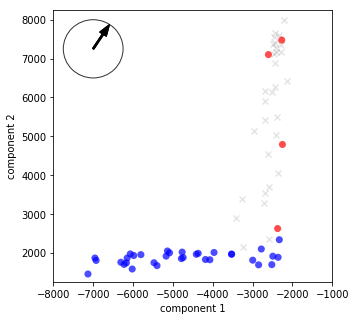

In [360]:
cav_params = xx[1]
idx =  xx[0]

#cav_params = original_CAV

x_train_new = np.delete(x_train, idx, axis=0)
y_train_new = np.delete(y_train, idx, axis=0)

light_blue, light_red = '#b3b8fb', '#f6889f'
fig = plt.figure(figsize=[5,5])

# train
color_train = ['red' if y == 0 else 'blue' for y in y_train_new]
train_embed = np.dot(x_train_new,pca_c.T)
plt.scatter(train_embed[:,0], train_embed[:,1], color = color_train, alpha = .7,linewidths=0,s=50)

old_train_embed = np.dot(x_train,pca_c.T)
for i in idx:
    plt.scatter(old_train_embed[i][0], old_train_embed[i][1], color = 'k', alpha = .1, marker='x')

x0,x1 = -70,185
ax = plt.gca()
radius = 30
circ = plt.Circle((x0,x1), radius=radius, edgecolor='black', facecolor='white',zorder=4,alpha=.8)
ax.add_patch(circ)

cav_pca = np.dot(cav_params,pca_c.T)
arrow_start = [x0,x1]
cav_norm = vec_norm(cav_pca) * radius
my_arrow = plt.arrow(arrow_start[0], arrow_start[1], cav_norm[0], cav_norm[1],width=2,length_includes_head=True,head_width=6,fc='k', ec=None, alpha = 1,zorder=5)
a0 = ax.add_patch(my_arrow)

cav_orig = original_CAV
cav_pca = np.dot(cav_orig,pca_c.T)
arrow_start = [x0,x1]
cav_norm_1 = vec_norm(cav_pca) * radius
my_arrow = plt.arrow(arrow_start[0], arrow_start[1], cav_norm_1[0], cav_norm_1[1],width=2,length_includes_head=True,head_width=6,fc='k', ec=None, alpha = .1,zorder=5)
a0 = ax.add_patch(my_arrow)



plt.xlim([-8000,-1000])
plt.ylim([1250,8250])

x1,x2 = -7000,7250
ax = plt.gca()
radius = 750
circ = plt.Circle((x1,x2), radius=radius, edgecolor='black', facecolor='white',zorder=4,alpha=.8)
#el = plt.Ellipse(
#ax.add_artist(Ellipse((x1,x2), radius*2, radius*2*(100/80),edgecolor='black', facecolor='white',zorder=4,alpha=.8))
ax.add_patch(circ)

#c0,c1 =  np.dot(pca_c,original_CAV)
#arrow_start = [x1,x2]
#cav_norm = vec_norm(np.array([c0,c1])) * radius
#cav_norm = [0,8]
#my_arrow = plt.arrow(arrow_start[0], arrow_start[1], cav_norm[0], cav_norm[1],width=40,length_includes_head=True,head_width=200,fc='k', ec=None, alpha = .1,zorder=5)
#a0 = ax.add_patch(my_arrow)

c0,c1 =  np.dot(pca_c,cav_params)
arrow_start = [x1,x2]
cav_norm = vec_norm(np.array([c0,c1])) * radius
#cav_norm = [0,8]
my_arrow = plt.arrow(arrow_start[0], arrow_start[1], cav_norm[0], cav_norm[1],width=40,length_includes_head=True,head_width=200,fc='k', ec=None, alpha = 1,zorder=5)
a0 = ax.add_patch(my_arrow)


#my_xlim = plt.xlim([-110,165])
#my_ylim = plt.ylim([-50,225])
_,_ = plt.xlabel('component 1'),plt.ylabel('component 2')

#_,_ = plt.xticks([], []),plt.yticks([], [])
plt.savefig('new_figs/tmp.png',dpi=200,bbox_inches='tight')

In [165]:
## Distance from mean

In [228]:
d_dict = {}

In [279]:
concept_p = 'horizontal'
layer = 'mixed9'
this_key = layer + '-' + concept_p
acts_p,_ = get_acts_for_concept(concept_p,layer)

In [280]:
mu_p = acts_p.mean(axis=0)

In [281]:

d_list = np.empty(acts_p.shape[0])
for idx in range(acts_p.shape[0]):
    d = euclidean_distance(acts_p[idx],mu_p)
    d_list[idx] = d

In [282]:
d_dict[this_key] = d_list.mean()

In [283]:
d_dict[this_key]

67.67777684420396

In [284]:
d_dict

{'mixed6-grassland_sub_1': 175.20645937425581,
 'mixed6-striped_sub_1': 147.11233198467554,
 'mixed6-yellow_sub_1': 178.4088268112329,
 'mixed6-random500_0': 192.72910680838737,
 'mixed6-N_0': 188.7652119528412,
 'mixed6-grid_sub_1': 135.01883992640936,
 'mixed6-dotted_sub_1': 152.06560611746747,
 'mixed6-horizontal': 157.1332254601986,
 'mixed9-horizontal': 67.67777684420396}

In [26]:
from sklearn.svm import SVC

In [27]:
def make_orig_cav(x_train,y_train):
    lm = linear_model.SGDClassifier(alpha=.1,max_iter=1000)
    lm.fit(x_train, y_train)
    this_cav = -lm.coef_[0]
    return this_cav

def make_log_cav(x_train,y_train):
    lm = linear_model.LogisticRegression()
    lm.fit(x_train, y_train)
    this_cav = -lm.coef_[0]
    return this_cav

def make_orig_cav_seed(x_train,y_train,seed):
    lm = linear_model.SGDClassifier(alpha=.1,random_state=seed)
    lm.fit(x_train, y_train)
    this_cav = -lm.coef_[0]
    return this_cav

def make_SVM_cav(x_train,y_train,C):
    lm = SVC(kernel = 'linear',random_state=3,C=C)
    lm.fit(x_train, y_train)
    this_cav = -lm.coef_[0]
    return this_cav

In [11]:
def comp_tcav(target_class,this_cav,class_acts,bottleneck_name):
    count = 0
    class_id = mymodel.label_to_id(target_class)

    for i in range(len(class_acts)):
        act_at_idx = np.expand_dims(class_acts[i], 0)
        if get_dir(act_at_idx,class_id,this_cav,bottleneck_name):
            count += 1
    score = float(count) / float(len(class_acts))
    return score

def get_dir(acts, class_id, this_cav, bottleneck_name):
    grads = sess.run(mymodel.bottlenecks_gradients[bottleneck_name], 
                 {mymodel.bottlenecks_tensors[bottleneck_name]: acts,
                 mymodel.y_input: [class_id]})
                     
    grad = np.reshape(grads, -1)
    dot_prod = np.dot(grad, this_cav)

    return dot_prod < 0

In [12]:
from sklearn import linear_model

In [13]:
def make_orig_cav_seed(x_train,y_train,seed):
    lm = linear_model.SGDClassifier(alpha=.1,random_state=seed)
    lm.fit(x_train, y_train)
    this_cav = -lm.coef_[0]
    return this_cav

In [14]:
def get_magnitude_and_grad(acts, class_id, this_cav, bottleneck_name):
    grads = sess.run(mymodel.bottlenecks_gradients[bottleneck_name], 
                 {mymodel.bottlenecks_tensors[bottleneck_name]: acts,
                 mymodel.y_input: [class_id]})
                     
    grad = np.reshape(grads, -1)
    dot_prod = np.dot(grad, this_cav)

    return dot_prod,grad


def get_magnitude_list(target_class,this_cav,class_acts,bottleneck_name):
    class_id = mymodel.label_to_id(target_class)
    magnitude_list = []
    for i in range(len(class_acts)):
        act_at_idx = np.expand_dims(class_acts[i], 0)
        this_mag = get_magnitude(act_at_idx,class_id,this_cav,bottleneck_name)
        magnitude_list.append(this_mag)
    return np.array(magnitude_list)

def get_magnitude(acts, class_id, this_cav, bottleneck_name):
    grads = sess.run(mymodel.bottlenecks_gradients[bottleneck_name], 
                 {mymodel.bottlenecks_tensors[bottleneck_name]: acts,
                 mymodel.y_input: [class_id]})
                     
    grad = np.reshape(grads, -1)
    dot_prod = np.dot(grad, this_cav)

    return dot_prod

In [15]:
#len(imgs)

In [188]:
cav_1 = this_cav.cavs[0]
cav_1 = cav_1.reshape(-1,1)

pred_1_shaped = pred_1.squeeze().reshape(-1,1)
cos = cosine_similarity(cav_1,pred_1_shaped)

pred_1_pert_shaped = pred_1_pert.squeeze().reshape(-1,1)
cos_pert = cosine_similarity(cav_1,pred_1_pert_shaped)

print(cos,cos_pert)

[-0.05537518] [0.24518335]


In [211]:
act = pred_1
flat_act = np.reshape(act, -1)
alpha = 2
cav_from_class = this_cav.cavs[this_cav.concepts.index(class_1)]
pert = flat_act + alpha * cav_from_class

In [16]:
def files_from_dir(a_dir):
    onlyfiles = [f for f in os.listdir(a_dir) if os.path.isfile(os.path.join(a_dir, f))]
    return onlyfiles

In [17]:
def get_L2(act_for_L2):
    return np.linalg.norm(act_for_L2,2,axis = 0) / act_for_L2.shape[0]

In [18]:
np.linalg.norm(act_for_L1.T,2,axis = 1) / act_for_L1.shape[1]

NameError: name 'act_for_L1' is not defined

In [19]:
def get_L1(act_for_L1):
    return np.linalg.norm(act_for_L1.T,1,axis = 1) / act_for_L1.shape[1]

def make_L1_cav(x_train,y_train):
    x_train_p_list,x_train_n_list =[],[]
    for idx,a in enumerate(x_train):
        if y_train[idx] == 0:
            x_train_p_list.append(a)
        else:
            x_train_n_list.append(a)

    x_train_p, x_train_n = np.array(x_train_p_list),np.array(x_train_n_list)
    L1_cav = get_L1(x_train_p) - get_L1(x_train_n)
    return L1_cav

In [20]:
def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    scipy.misc.imsave(fname, pil_img)
    
def deprocess_image(x):
    # Util function to convert a tensor into a valid image.
    #if K.image_data_format() == 'channels_first':
    #    x = x.reshape((3, x.shape[2], x.shape[3]))
    #    x = x.transpose((1, 2, 0))
    #else:
    x = x.reshape((x.shape[0], x.shape[1], 3))
    #x /= 2.
    #x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def get_prediction(img):
    img = preprocess_input(img)
    preds = sess.run(endpoints_v3['prediction'], {endpoints_v3['input']: img})
    top = decode_predictions(preds, top=3)
    return top

preprocess_input

## define functions
def vector_norm(vec):
    norm_const = math.sqrt(vec[0]*vec[0] + vec[1]*vec[1])
    return vec / norm_const

def vec_norm(vec):
    return  vec / np.linalg.norm(vec)

## CAV distance
def euclidean_distance(a,b):
    return np.linalg.norm(a-b)

def prep2(filename):
    shape=(299, 299)
    img = np.array(PIL.Image.open(open(filename, 'rb')).convert('RGB').resize(shape, PIL.Image.BILINEAR))
    # Normalize pixel values to between 0 and 1.
    img = np.float32(img) / 255.0
    if not (len(img.shape) == 3 and img.shape[2] == 3):
        return None
    else:
        return np.expand_dims(img,axis=0)

In [21]:

def prep2(filename):
    shape=(299, 299)
    img = np.array(PIL.Image.open(open(filename, 'rb')).convert('RGB').resize(shape, PIL.Image.BILINEAR))
    # Normalize pixel values to between 0 and 1.
    img = np.float32(img) / 255.0
    if not (len(img.shape) == 3 and img.shape[2] == 3):
        return None
    else:
        return img

this_img = np.expand_dims(prep2('concepts/random500_0/ILSVRC2012_val_00001172.JPEG'),axis=0)
    
    
    
def get_acts_for_concept(concept,layer):
    concept_dir = os.path.join(working_dir,'concepts/'+concept)
    image_list = files_from_dir_ext(concept_dir,'jp')
    image_list.sort()

    act_path = os.path.join(working_dir,'final_acts/' + concept + '-' + layer + '.pkl')

    n = size_dict[layer]
    nn = size_dict_orig[layer]

    try:
        this_dict = pickle.load(open(act_path, 'rb'))
    except:
        this_dict = {}
        
    #print(nn)
    
    acts_ran = np.zeros((len(image_list),n))
    orig = np.zeros((len(image_list),nn[1],nn[2],nn[3]))
    
    for idx,image_path in enumerate(image_list):
        if image_path not in this_dict:
            img = prep2(os.path.join(concept_dir,image_path))
            this_img = np.expand_dims(img, axis=0)
            acts_orig = get_acts_for_layer_new(layer,this_img)
            acts_ran[idx] = acts_orig.reshape(-1)
            orig[idx] = acts_orig
            this_dict[image_path] = (acts_orig.reshape(-1),acts_orig)
        else:
            acts_ran[idx],orig[idx] = this_dict[image_path]
            #print('acts already exist')

    pickle.dump(this_dict,open(act_path, 'wb'))
    
    return acts_ran,orig
def files_from_dir_ext(a_dir,ext):
    onlyfiles = [f for f in os.listdir(a_dir) if os.path.isfile(os.path.join(a_dir, f))]
    this_ext = [e for e in onlyfiles if ext in e.lower()]
    return this_ext
layer_dict = dict([(layer.name, layer) for layer in model.layers])
sess = K.get_session()


acts_mixed0_f = K.function([model.input],[layer_dict['mixed0'].output])
acts_mixed1_f = K.function([model.input],[layer_dict['mixed1'].output])
acts_mixed2_f = K.function([model.input],[layer_dict['mixed2'].output])
acts_mixed3_f = K.function([model.input],[layer_dict['mixed3'].output])
acts_mixed4_f = K.function([model.input],[layer_dict['mixed4'].output])
acts_mixed5_f = K.function([model.input],[layer_dict['mixed5'].output])
acts_mixed6_f = K.function([model.input],[layer_dict['mixed6'].output])
acts_mixed7_f = K.function([model.input],[layer_dict['mixed7'].output])
acts_mixed8_f = K.function([model.input],[layer_dict['mixed8'].output])
acts_mixed9_f = K.function([model.input],[layer_dict['mixed9'].output])
acts_mixed10_f = K.function([model.input],[layer_dict['mixed10'].output])

def get_acts_for_layer_new(layer_name,input_img):
    acts = None
    if layer_name=='mixed0':
        acts = acts_mixed0_f([input_img])[0]
    if layer_name=='mixed1':
        acts = acts_mixed1_f([input_img])[0]
    if layer_name=='mixed2':
        acts = acts_mixed2_f([input_img])[0]
    if layer_name=='mixed3':
        acts = acts_mixed3_f([input_img])[0]
    if layer_name=='mixed4':
        acts = acts_mixed4_f([input_img])[0]
    if layer_name=='mixed5':
        acts = acts_mixed5_f([input_img])[0]
    if layer_name=='mixed6':
        acts = acts_mixed6_f([input_img])[0]
    if layer_name=='mixed7':
        acts = acts_mixed7_f([input_img])[0]
    if layer_name=='mixed8':
        acts = acts_mixed8_f([input_img])[0]
    if layer_name=='mixed9':
        acts = acts_mixed9_f([input_img])[0]
    if layer_name=='mixed10':
        acts = acts_mixed10_f([input_img])[0]
    
    return acts


bn_names = ['mixed0','mixed1','mixed2','mixed3','mixed4','mixed5','mixed6','mixed7','mixed8','mixed9','mixed10']

size_dict = {}
for bn in bn_names:
    acts_orig = get_acts_for_layer_new(bn,this_img)
    size_dict[bn] = acts_orig.reshape(-1).shape[0]
    
size_dict_orig = {}
for bn in bn_names:
    acts_orig = get_acts_for_layer_new(bn,this_img)
    size_dict_orig[bn] = acts_orig.shape

In [ ]:
try:
    remove_10 = pickle.load(open(f'remove_10_{ext}.pkl','rb'))
except:
    remove_10 = []

for i in range(n):
    np.random.shuffle(p_idx)
    x_train_new = np.delete(x_train, p_idx[:10], axis=0)
    y_train_new = np.delete(y_train, p_idx[:10], axis=0)
    
    if is_mean:
        x_train_p_list,x_train_n_list =[],[]
        for idx_2,a in enumerate(x_train_new):
            if y_train_new[idx_2] == 0:
                x_train_p_list.append(a)
            else:
                x_train_n_list.append(a)

        x_train_p,x_train_n = None,None
        x_train_p, x_train_n = np.array(x_train_p_list),np.array(x_train_n_list)

        mu_p,mu_n = None,None
        mu_p = (x_train_p).mean(axis=0)
        mu_n = (x_train_n).mean(axis=0)
        cav_params = mu_p - mu_n

    if is_marg:
        cav_seeds = np.empty((100,size_dict[layer]))
        for seed in range(100):
            cav_seeds[seed] = make_orig_cav_seed(x_train_new,y_train_new,seed)
        cav_params = cav_seeds.meadef n(axis=0)

    if is_log:
        cav_params = make_log_cav(x_train_new,y_train_new)
    if is_svm:
        cav_params = make_SVM_cav(x_train_new,y_train_new,.1)
    new_score = comp_tcav(target_class_name,cav_params,acts_class,layer)

    cosine_sim = cosine_similarity(cav_params,original_CAV)
    remove_10.append([idx,cav_params,cosine_sim,new_score])
    print(i)

pickle.dump(remove_10,open(f'remove_10_{ext}.pkl','wb'))






try:
    remove_20 = pickle.load(open(f'remove_20_{ext}.pkl','rb'))
except:
    remove_20 = []

for i in range(n):
    np.random.shuffle(p_idx)
    x_train_new = np.delete(x_train, p_idx[:20], axis=0)
    y_train_new = np.delete(y_train, p_idx[:20], axis=0)
    
    x_train_p_list,x_train_n_list =[],[]
    for idx_2,a in enumerate(x_train_new):
        if y_train_new[idx_2] == 0:
            x_train_p_list.append(a)
        else:
            x_train_n_list.append(a)

    x_train_p,x_train_n = None,None
    x_train_p, x_train_n = np.array(x_train_p_list),np.array(x_train_n_list)

    mu_p,mu_n = None,None
    mu_p = (x_train_p).mean(axis=0)
    mu_n = (x_train_n).mean(axis=0)
    cav_params = mu_p-mu_n

    #cav_params = make_log_cav(x_train_new,y_train_new)

    new_score = comp_tcav(target_class_name,cav_params,acts_class,layer)

    cosine_sim = cosine_similarity(cav_params,original_CAV)
    remove_20.append([idx,cav_params,cosine_sim,new_score])
    print(i)

pickle.dump(remove_20,open(f'remove_20_{ext}.pkl','wb'))

try:
    remove_30 = pickle.load(open(f'remove_30_{ext}.pkl','rb'))
except:
    remove_30 = []

for i in range(n):
    np.random.shuffle(p_idx)
    x_train_new = np.delete(x_train, p_idx[:30], axis=0)
    y_train_new = np.delete(y_train, p_idx[:30], axis=0)
    
    x_train_p_list,x_train_n_list =[],[]
    for idx_2,a in enumerate(x_train_new):
        if y_train_new[idx_2] == 0:
            x_train_p_list.append(a)
        else:
            x_train_n_list.append(a)

    x_train_p,x_train_n = None,None
    x_train_p, x_train_n = np.array(x_train_p_list),np.array(x_train_n_list)

    mu_p,mu_n = None,None
    mu_p = (x_train_p).mean(axis=0)
    mu_n = (x_train_n).mean(axis=0)
    cav_params = mu_p-mu_n

    #cav_params = make_log_cav(x_train_new,y_train_new)

    new_score = comp_tcav(target_class_name,cav_params,acts_class,layer)

    cosine_sim = cosine_similarity(cav_params,original_CAV)
    remove_30.append([idx,cav_params,cosine_sim,new_score])
    print(i)

pickle.dump(remove_30,open(f'remove_30_{ext}.pkl','wb'))